<a href="https://colab.research.google.com/github/AmiBuch/exp-forecasting-methods/blob/main/scripts/darts/128_12_baselining_darts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install darts
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from scipy import stats
from darts.metrics import metrics

                     PM2.5 (µg/m³)  PM10 (µg/m³)  NO (µg/m³)  NO2 (µg/m³)  \
Timestamp                                                                   
2022-01-01 00:00:00        273.550       386.220     249.030       54.670   
2022-01-01 01:00:00        268.870       432.990     294.770       50.750   
2022-01-01 02:00:00        258.020       396.280     247.480       50.370   
2022-01-01 03:00:00        194.910       297.690     152.660       45.180   
2022-01-01 04:00:00        198.000       314.810     123.040       41.780   
...                            ...           ...         ...          ...   
2023-12-31 19:00:00        222.608       412.838      43.690       18.388   
2023-12-31 20:00:00        213.442       366.385      42.690       15.850   
2023-12-31 21:00:00        234.645       346.625      40.540       15.850   
2023-12-31 22:00:00        206.625       340.345      39.148       13.442   
2023-12-31 23:00:00        175.335       277.898      39.755       12.882   

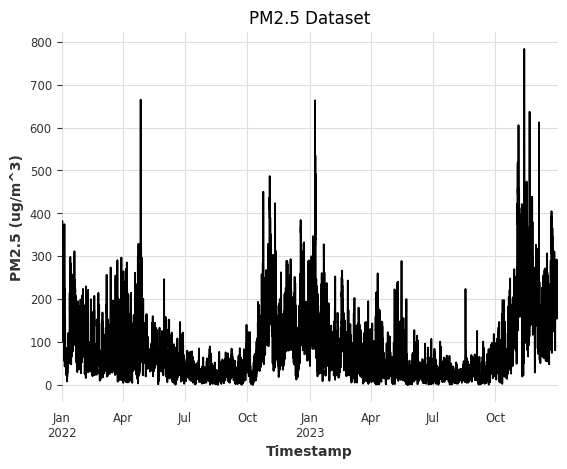

Timestamp
2022-01-01 00:00:00    5.615133
2022-01-01 01:00:00    5.597940
2022-01-01 02:00:00    5.556905
2022-01-01 03:00:00    5.277655
2022-01-01 04:00:00    5.293305
                         ...   
2023-12-31 19:00:00    5.409895
2023-12-31 20:00:00    5.368039
2023-12-31 21:00:00    5.462326
2023-12-31 22:00:00    5.335734
2023-12-31 23:00:00    5.172386
Name: PM2.5 (µg/m³), Length: 17520, dtype: float64


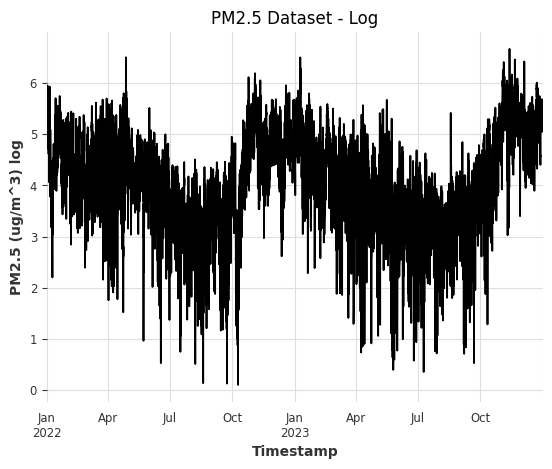

In [ ]:
df = pd.read_csv('combined_interplolated_IGI_airport.csv')
df = df.set_index('Timestamp')
df.index = pd.to_datetime(df.index)
print(df)
df_new = df['PM2.5 (µg/m³)']
print(df_new)
df_new.plot(label="values")
plt.title("PM2.5 Dataset")
plt.ylabel("PM2.5 (ug/m^3)")
plt.show()
# pre-processing to avoid negative valued forecasts
df_log = np.log(df_new + 1)
print(df_log)
df_log.plot(label="logged values")
plt.title("PM2.5 Dataset - Log")
plt.ylabel("PM2.5 (ug/m^3) log")
plt.show()

# Local Forecasting Models


## NaiveMean


In [ ]:
from darts.models import NaiveMean
model = NaiveMean()

0


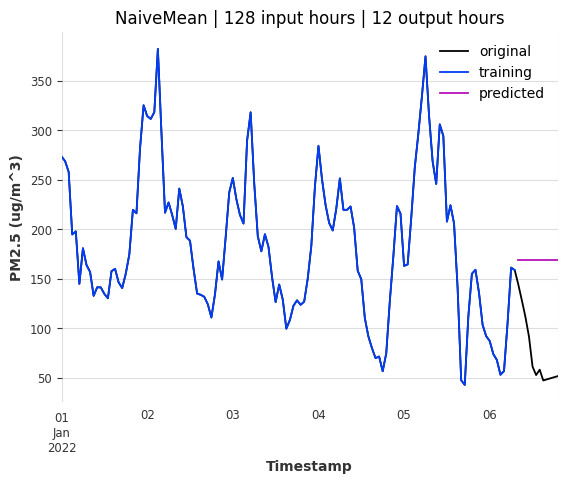

mae for this run : 93.83121014965168
1000


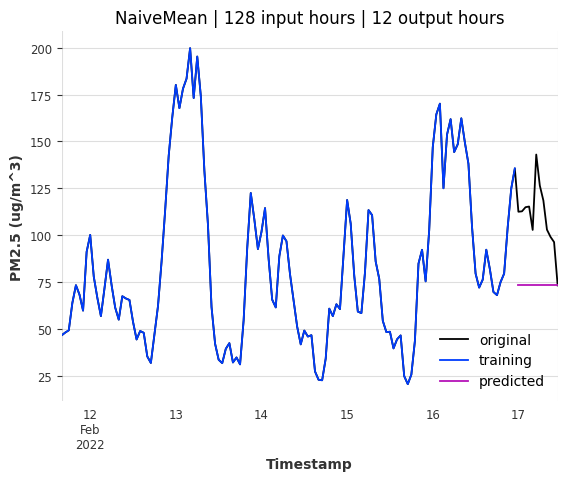

mae for this run : 36.39445669593001
2000


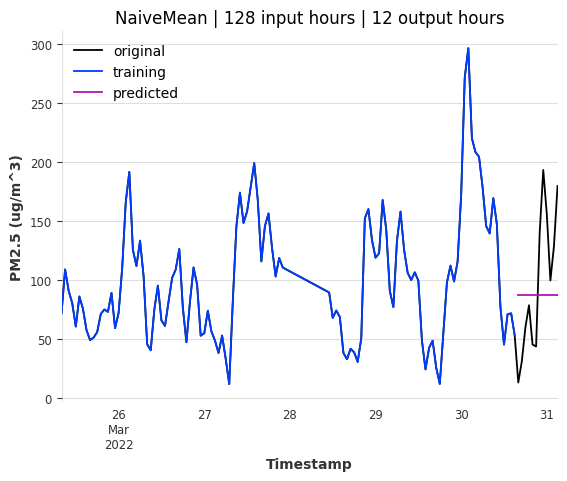

mae for this run : 52.24583333333333
3000


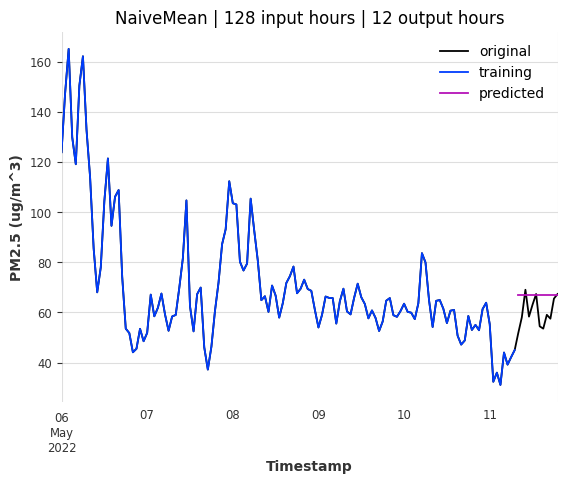

mae for this run : 7.075085561202802
4000


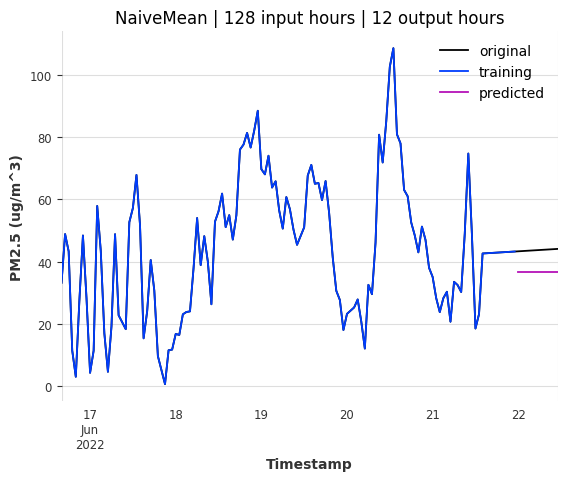

mae for this run : 7.031872376701339
5000


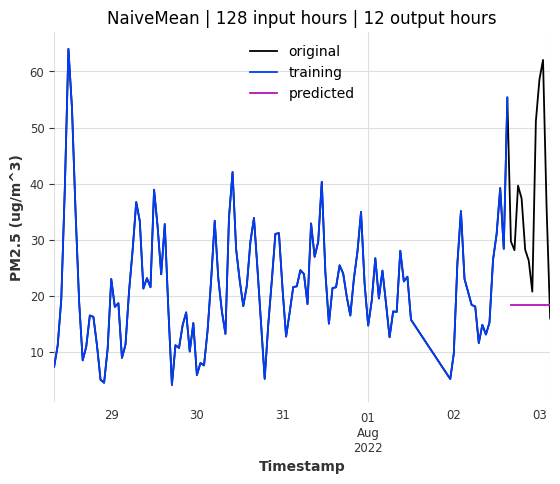

mae for this run : 18.110179771663198
6000


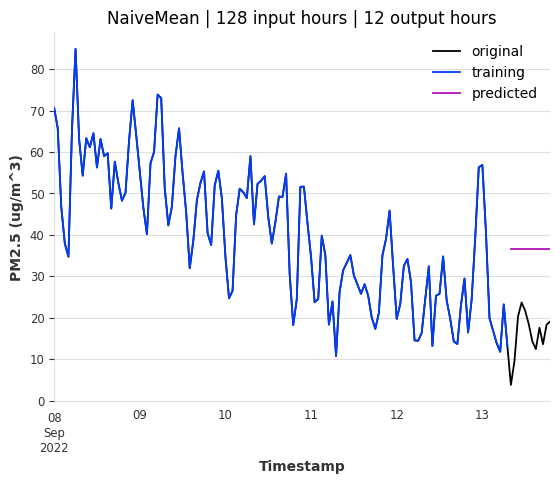

mae for this run : 20.452393868630164
7000


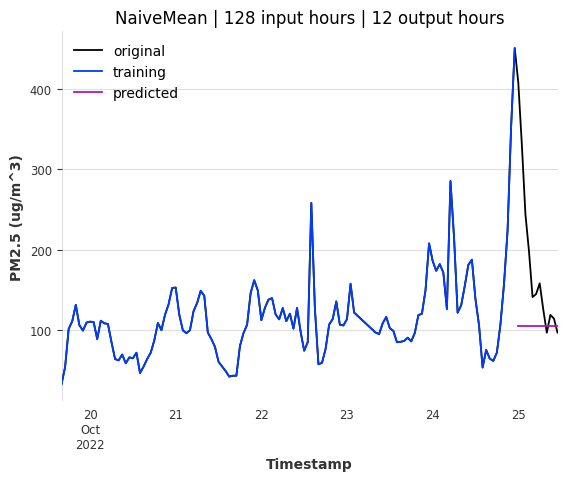

mae for this run : 79.33423411160727
8000


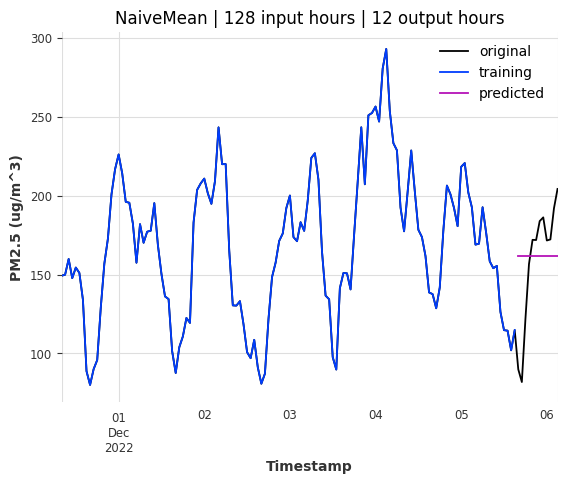

mae for this run : 29.69482055706976
9000


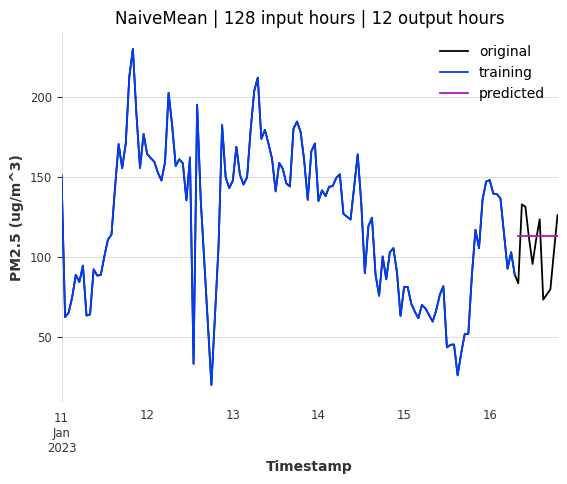

mae for this run : 19.158653983420994
10000


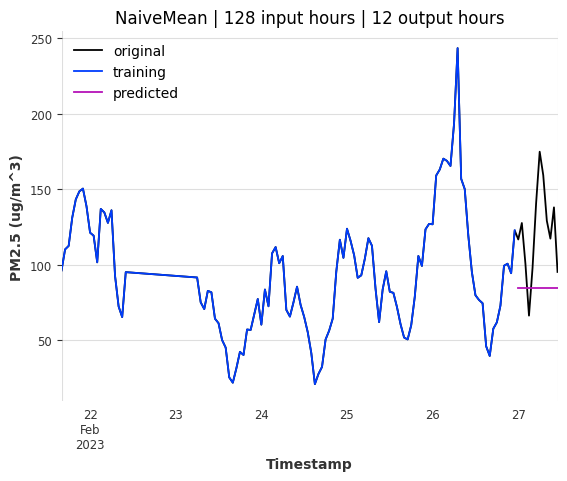

mae for this run : 40.22550124931492
11000


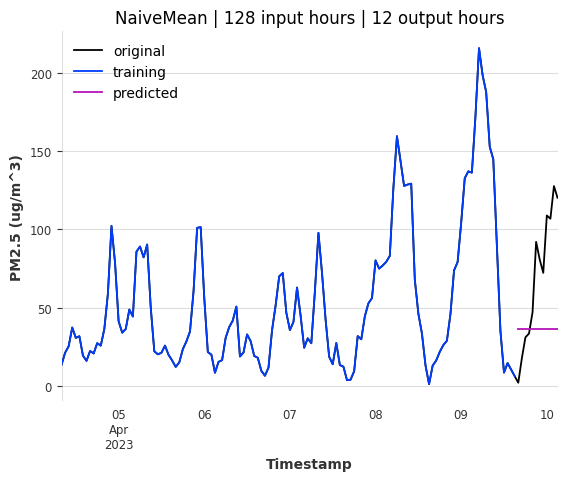

mae for this run : 43.77055966624179
12000


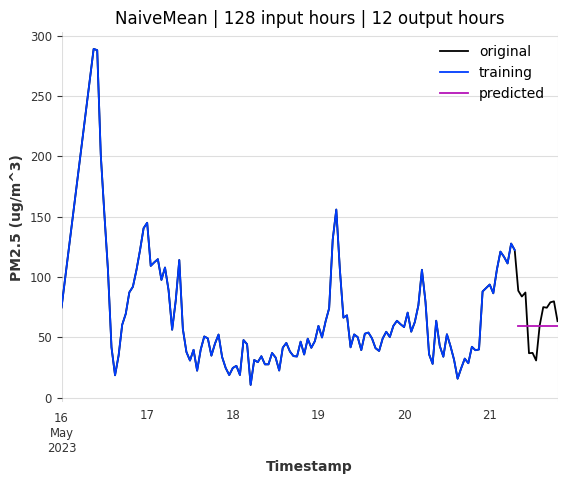

mae for this run : 19.289725306941033
13000


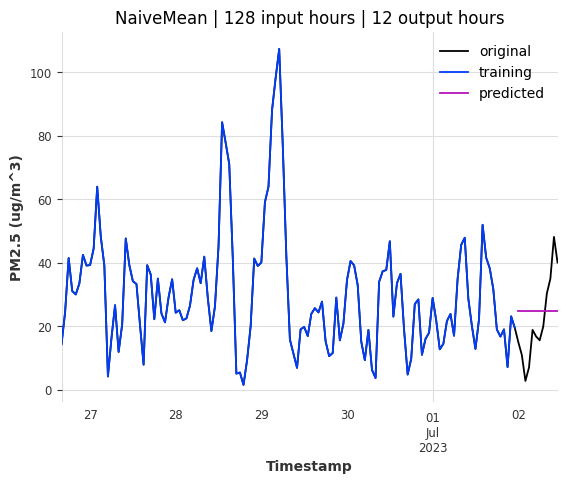

mae for this run : 12.171645505334967
14000


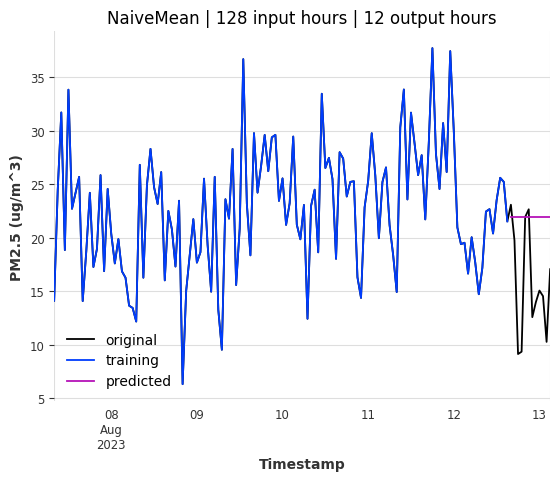

mae for this run : 6.475533389693942
15000


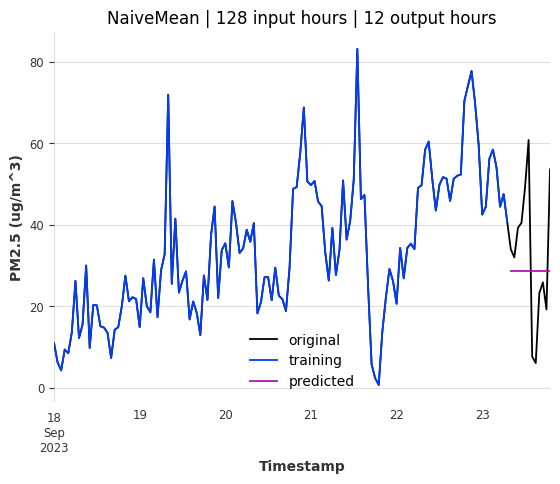

mae for this run : 14.187517984700735
16000


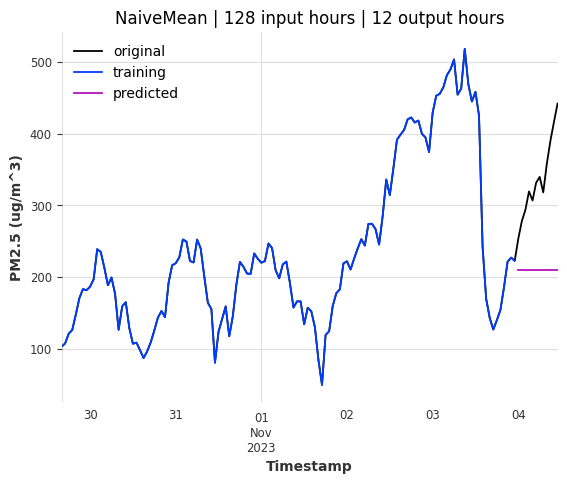

mae for this run : 128.03303115043758
17000


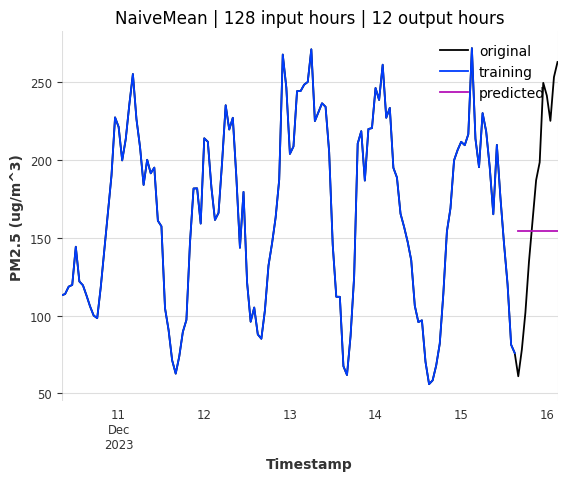

mae for this run : 65.423011149679
[93.83121014965168, 36.39445669593001, 52.24583333333333, 7.075085561202802, 7.031872376701339, 18.110179771663198, 20.452393868630164, 79.33423411160727, 29.69482055706976, 19.158653983420994, 40.22550124931492, 43.77055966624179, 19.289725306941033, 12.171645505334967, 6.475533389693942, 14.187517984700735, 128.03303115043758, 65.423011149679]
Overall MAE: 38.49473698953081


In [ ]:
inputhours = 128
outputhours = 12
mae_list = []
for start_idx in range(0, len(df_log) - (inputhours + outputhours), 1000):
    print(start_idx)
    current_chunk = df_log.iloc[start_idx:start_idx + inputhours + outputhours]
    input_df = current_chunk.head(inputhours)

    # Convert to TimeSeries
    input_series = pd.Series(input_df, index=input_df.index)
    input_series.index = pd.to_datetime(input_series.index)
    ts = TimeSeries.from_series(input_series)

    model.fit(ts)
    pred = model.predict(outputhours)

    # Extract prediction values and create a date range for the prediction
    pred_values = pred.values().flatten()  # Assuming `pred.values()` gives the forecasted values
    pred_index = pd.date_range(start=input_series.index[-1], periods=outputhours + 1, freq='H')[1:]
    pred_series = pd.Series(pred_values, index=pred_index)
    # print(pred_series)
    # Reverse the logarithmic transformation
    current_chunk_original = np.exp(current_chunk.values) - 1
    input_series_original = np.exp(input_series.values) - 1
    pred_series_original = np.exp(pred_series.values) - 1
    # print(current_chunk_original)
    current_new = pd.Series(current_chunk_original, index=current_chunk.index)
    train_new = pd.Series(input_series_original, index=input_series.index)
    pred_new = pd.Series(pred_series_original, index=pred_index)
    actual_values = current_new[inputhours:]
    mae = np.mean(np.abs(pred_new.values - actual_values.values))
    mae_list.append(mae)
    #print(pred_series_original)
    # Plotting
    fig, ax = plt.subplots()
    current_new.plot(ax=ax, label="original")
    train_new.plot(ax=ax, label="training")
    pred_new.plot(ax=ax, label="predicted")
    plt.title("NaiveMean | 128 input hours | 12 output hours")
    plt.ylabel("PM2.5 (ug/m^3)")
    ax.legend()

    plt.show()
    print("mae for this run : " + str(mae))
    # print(metrics.ae(pd.Series(current_chunk), pred_new, intersect=True))
print(mae_list)
overall_mae = np.mean(mae_list)
print(f"Overall MAE: {overall_mae}")

## Naive Moving Average

In [ ]:
from darts.models import NaiveMovingAverage
model = NaiveMovingAverage(input_chunk_length = 24)


0


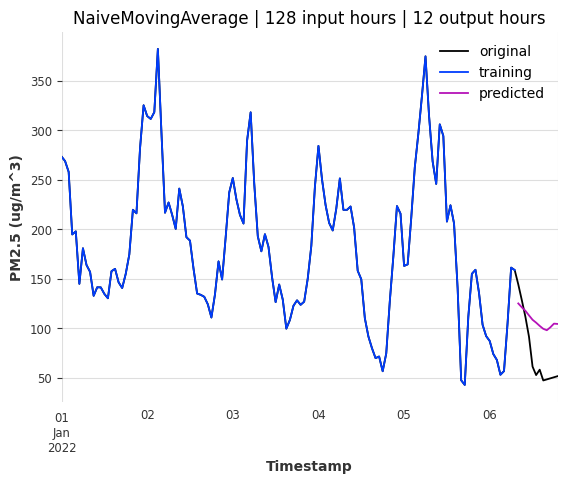

mae for this run : 38.20338919799057
1000


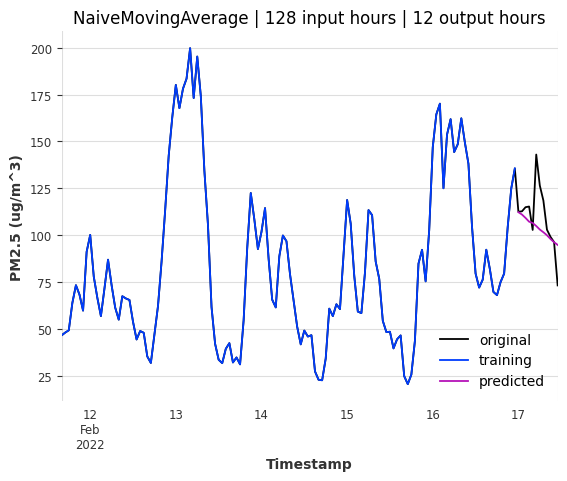

mae for this run : 10.313029466037134
2000


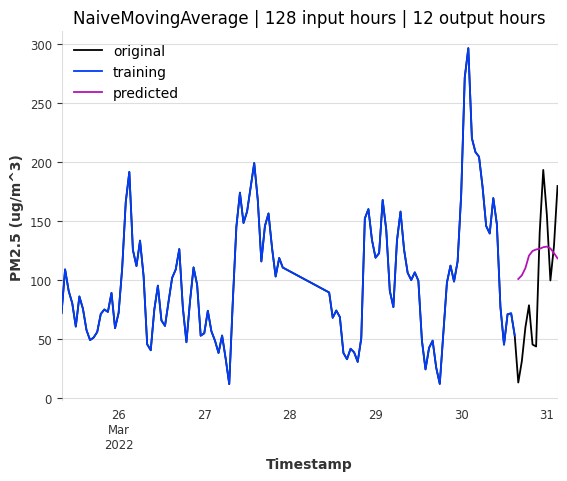

mae for this run : 51.40246979409064
3000


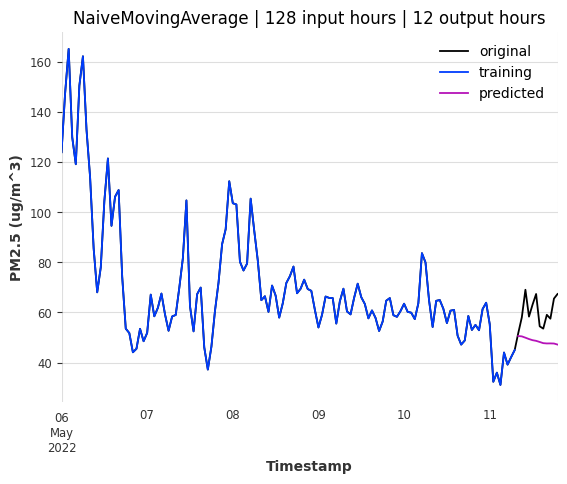

mae for this run : 11.776884418044913
4000


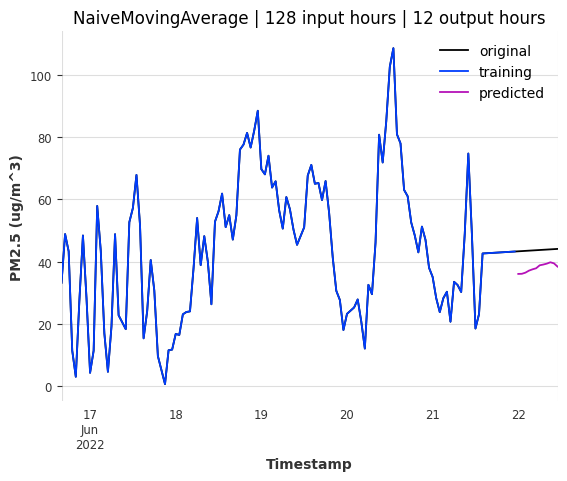

mae for this run : 5.696049593354196
5000


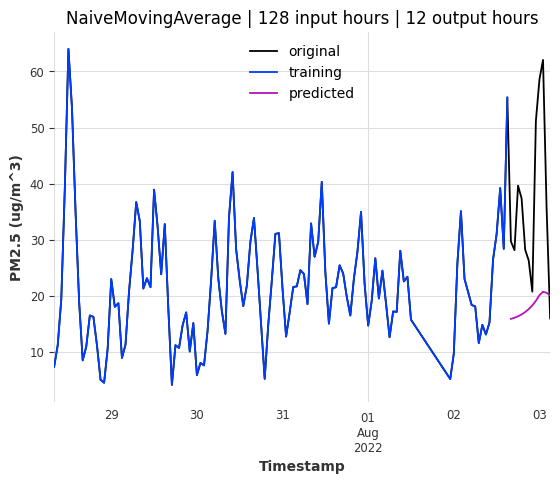

mae for this run : 18.586587442553917
6000


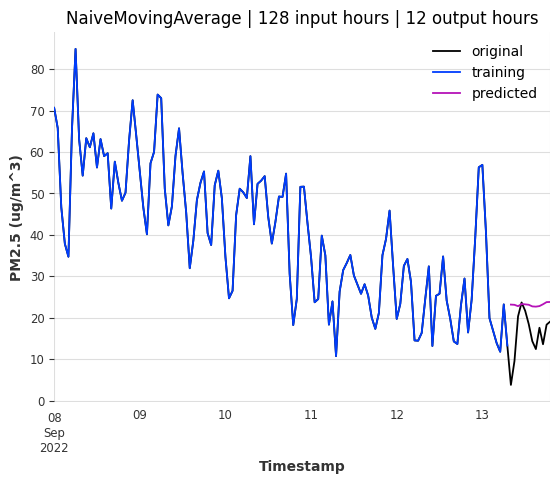

mae for this run : 7.143299042491999
7000


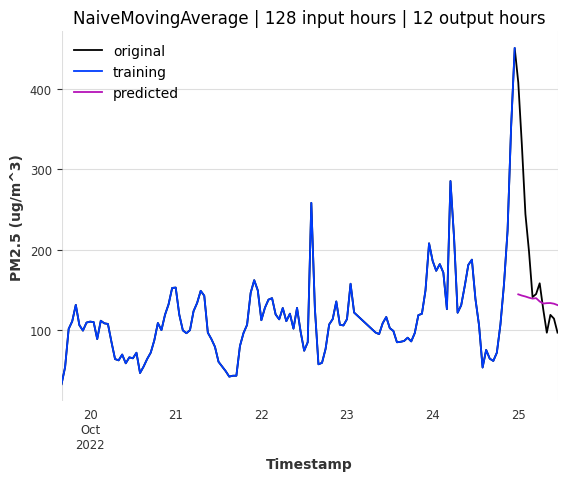

mae for this run : 62.71674195563734
8000


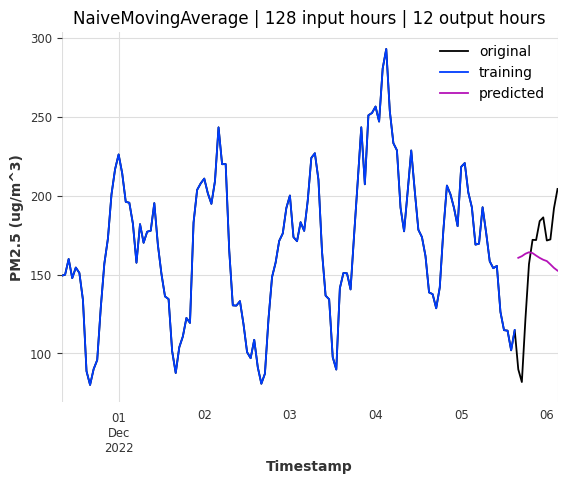

mae for this run : 32.24213590350526
9000


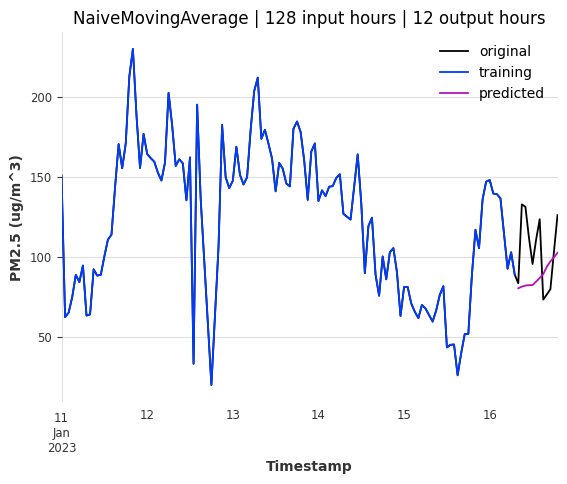

mae for this run : 23.91970828824994
10000


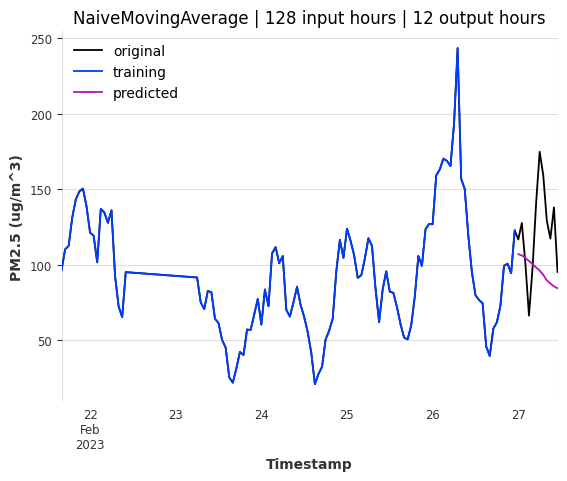

mae for this run : 32.80319548526114
11000


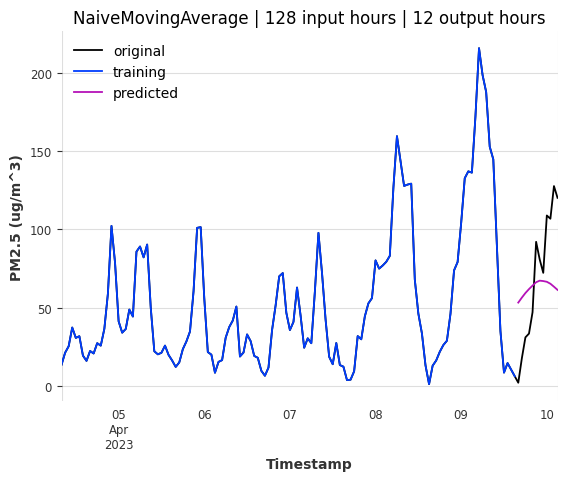

mae for this run : 34.63394854124801
12000


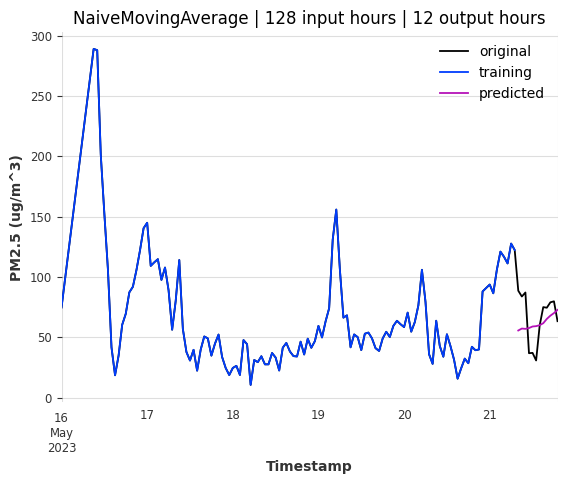

mae for this run : 17.818208203176823
13000


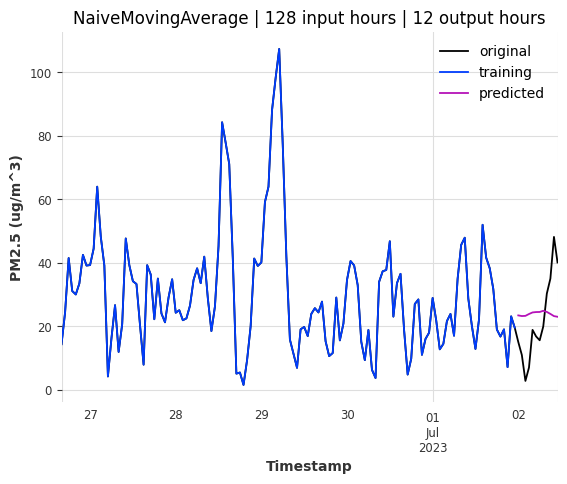

mae for this run : 11.9952218260313
14000


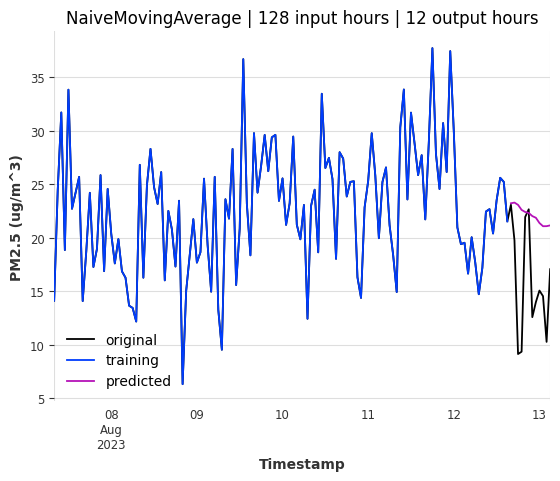

mae for this run : 6.390930807017636
15000


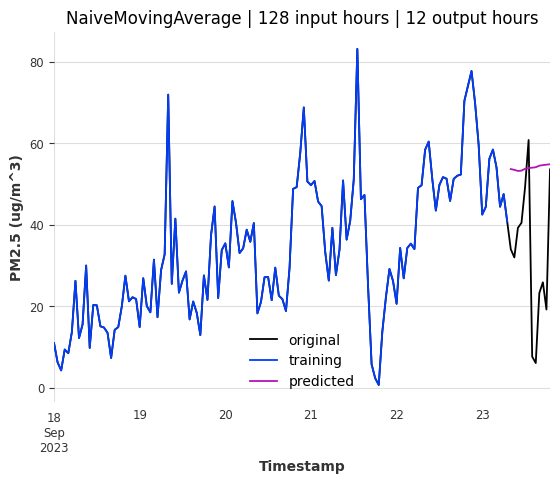

mae for this run : 22.57440200641284
16000


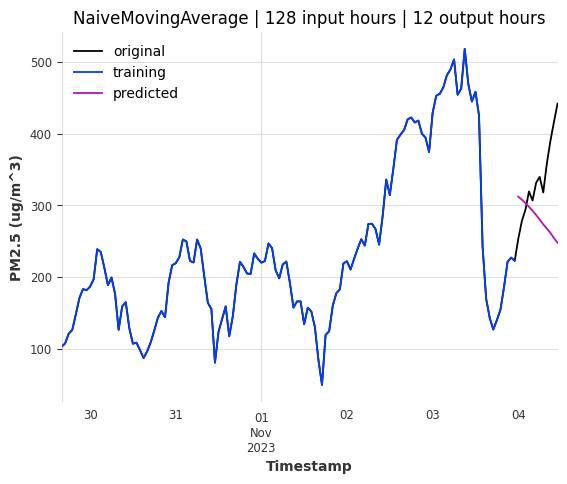

mae for this run : 71.49761693844196
17000


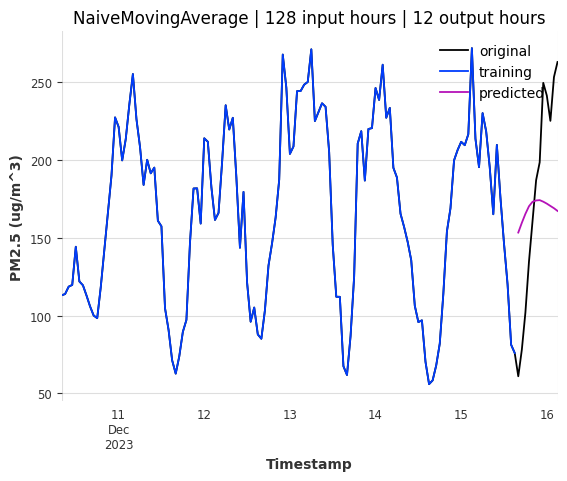

mae for this run : 58.63408258032356
[38.20338919799057, 10.313029466037134, 51.40246979409064, 11.776884418044913, 5.696049593354196, 18.586587442553917, 7.143299042491999, 62.71674195563734, 32.24213590350526, 23.91970828824994, 32.80319548526114, 34.63394854124801, 17.818208203176823, 11.9952218260313, 6.390930807017636, 22.57440200641284, 71.49761693844196, 58.63408258032356]
Overall MAE: 28.797105638326066


In [ ]:
inputhours = 128
outputhours = 12
mae_list = []
for start_idx in range(0, len(df_log) - (inputhours + outputhours), 1000):
    print(start_idx)
    current_chunk = df_log.iloc[start_idx:start_idx + inputhours + outputhours]
    input_df = current_chunk.head(inputhours)

    # Convert to TimeSeries
    input_series = pd.Series(input_df, index=input_df.index)
    input_series.index = pd.to_datetime(input_series.index)
    ts = TimeSeries.from_series(input_series)

    model.fit(ts)
    pred = model.predict(outputhours)

    # Extract prediction values and create a date range for the prediction
    pred_values = pred.values().flatten()  # Assuming `pred.values()` gives the forecasted values
    pred_index = pd.date_range(start=input_series.index[-1], periods=outputhours + 1, freq='H')[1:]
    pred_series = pd.Series(pred_values, index=pred_index)
    # print(pred_series)
    # Reverse the logarithmic transformation
    current_chunk_original = np.exp(current_chunk.values) - 1
    input_series_original = np.exp(input_series.values) - 1
    pred_series_original = np.exp(pred_series.values) - 1
    # print(current_chunk_original)
    current_new = pd.Series(current_chunk_original, index=current_chunk.index)
    train_new = pd.Series(input_series_original, index=input_series.index)
    pred_new = pd.Series(pred_series_original, index=pred_index)
    actual_values = current_new[inputhours:]
    mae = np.mean(np.abs(pred_new.values - actual_values.values))
    mae_list.append(mae)
    #print(pred_series_original)
    # Plotting
    fig, ax = plt.subplots()
    current_new.plot(ax=ax, label="original")
    train_new.plot(ax=ax, label="training")
    pred_new.plot(ax=ax, label="predicted")
    ax.legend()
    plt.title("NaiveMovingAverage | 128 input hours | 12 output hours")
    plt.ylabel("PM2.5 (ug/m^3)")
    filename = f"nma-128-12-{start_idx/1000}.png"
    plt.savefig(filename)
    plt.show()
    print("mae for this run : " + str(mae))
    # print(metrics.ae(pd.Series(current_chunk), pred_new, intersect=True))
print(mae_list)
overall_mae = np.mean(mae_list)
print(f"Overall MAE: {overall_mae}")


# Statistical Models

## ARIMA

### Step 1 : Dickey-Fuller test for stationary check

If p-value is more than 0.05, then series is non-stationary.

In [ ]:
from darts.models import ARIMA
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from statsmodels.tsa.stattools import adfuller
%pip install pmdarima
from pmdarima.arima import auto_arima

0
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-54.352, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=158.701, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-27.140, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=34.337, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=784.966, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-52.919, Time=0.63 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-53.138, Time=0.99 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-21.233, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-48.695, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-51.377, Time=0.47 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-37.354, Time=0.09 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 3.502 seconds
Best model order: p=1, d=0, q=1


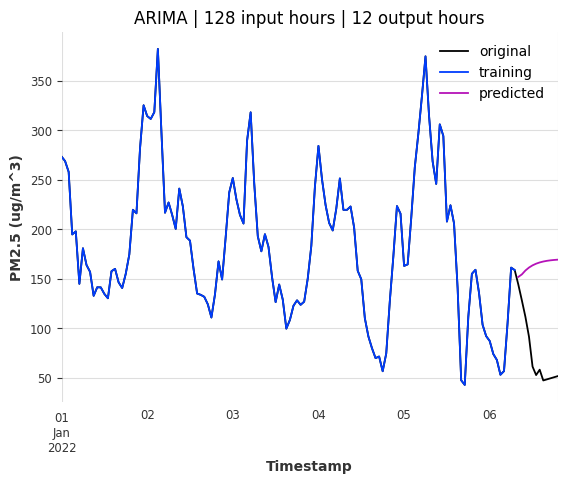

mae for this run : 88.98281117273343
1000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-38.278, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=200.103, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-8.638, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=68.468, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=741.139, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-39.742, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-39.224, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-38.361, Time=0.48 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-38.595, Time=0.36 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-40.206, Time=0.27 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=10.580, Time=0.33 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-42.868, Time=1.62 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-36.838, Time=1.12 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-37.443, Time=1.97 sec
 ARIMA(1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


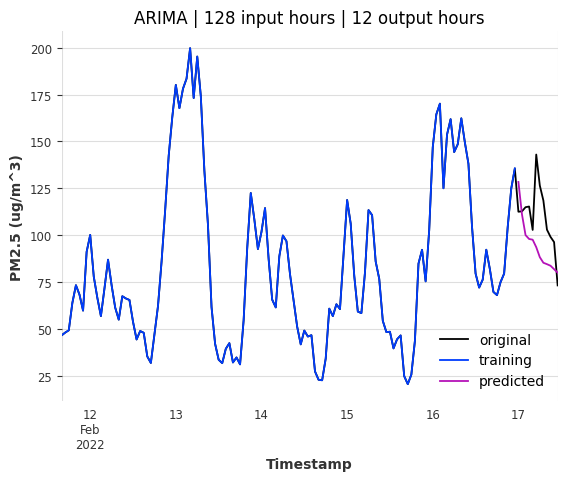

mae for this run : 19.22897346901429
2000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=99.977, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=214.734, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=111.094, Time=0.43 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=125.732, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=751.101, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=101.710, Time=1.63 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=100.891, Time=1.22 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=104.160, Time=0.90 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=106.438, Time=1.08 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=102.721, Time=1.40 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=129.177, Time=0.20 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 8.262 seconds
Best model order: p=1, d=0, q=1


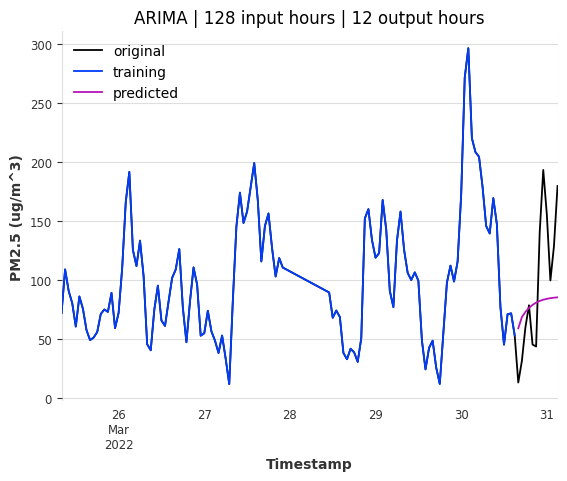

mae for this run : 46.950272299160844
3000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-110.066, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=65.976, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-106.592, Time=0.42 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-30.652, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=734.577, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-108.095, Time=1.75 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-108.252, Time=1.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-89.284, Time=0.45 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-108.702, Time=0.59 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-107.152, Time=2.00 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-96.034, Time=0.76 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 8.408 seconds
Best model order: p=1, d=0, q=1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


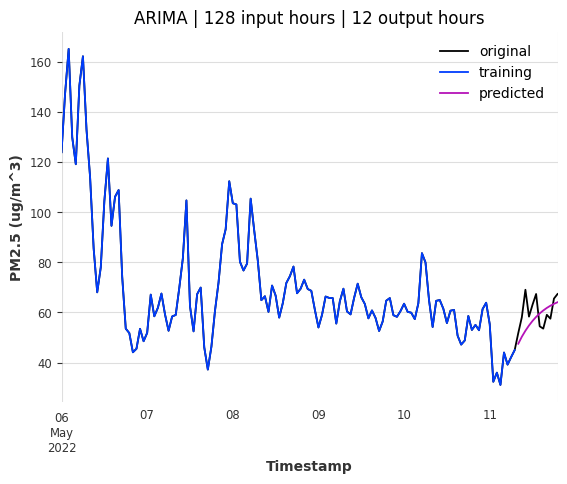

mae for this run : 6.110480994887151
4000
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=202.521, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=204.491, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=204.154, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=200.523, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.861 seconds
Best model order: p=0, d=1, q=0


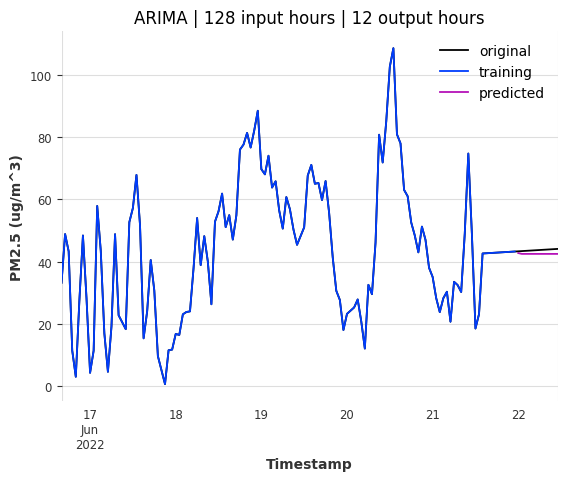

mae for this run : 1.193769614964469
5000
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=133.416, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=130.562, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=131.880, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=131.671, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=128.741, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.828 seconds
Best model order: p=0, d=1, q=0


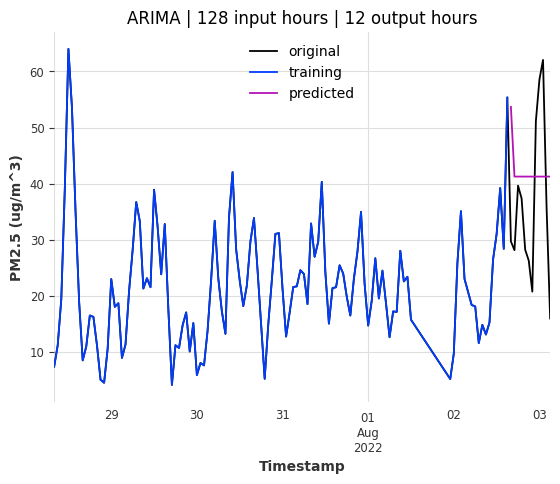

mae for this run : 14.152747895534207
6000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=51.968, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=168.918, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=51.486, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=94.019, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=696.962, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=52.130, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=53.968, Time=0.45 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.013 seconds
Best model order: p=1, d=0, q=0


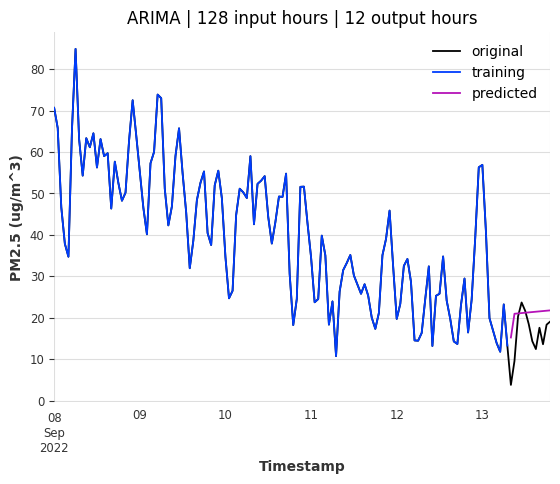

mae for this run : 5.294575014774078
7000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=14.157, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=141.925, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=18.503, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=59.644, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=760.321, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=16.140, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=16.137, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=28.322, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=14.530, Time=0.22 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=17.599, Time=0.43 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=27.391, Time=0.13 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.971 seconds
Best model order: p=1, d=0, q=1


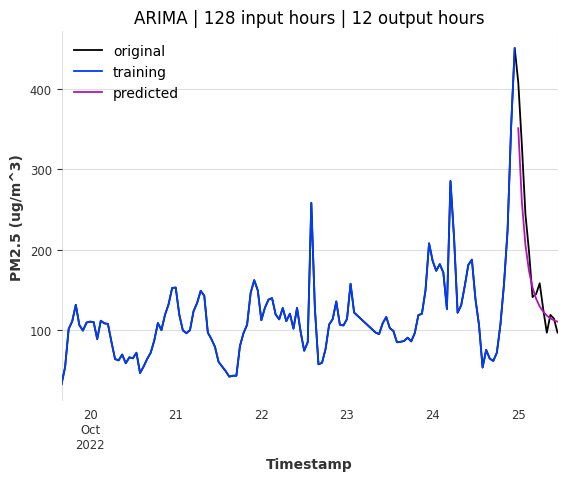

mae for this run : 23.402438241178853
8000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-159.634, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=51.108, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-146.364, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-63.769, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=782.463, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-159.034, Time=0.90 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-158.592, Time=0.76 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-122.600, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-161.023, Time=0.47 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-159.025, Time=0.64 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-157.111, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 4.408 seconds
Best model order: p=2, d=0, q=0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


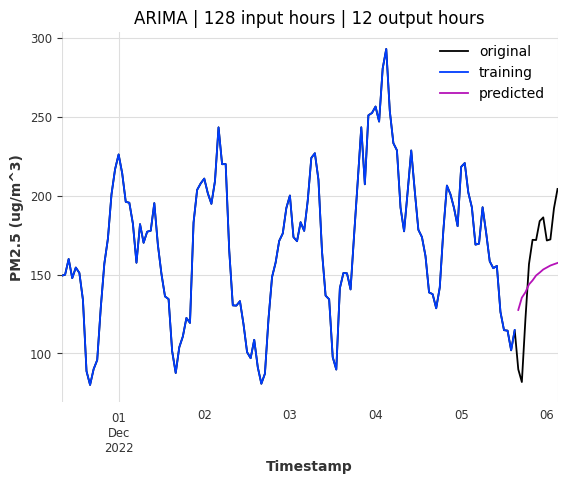

mae for this run : 29.290161993395856
9000
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=64.618, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76.258, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.504, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=64.942, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=74.279, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=65.288, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=68.548, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=66.984, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=62.618, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=62.947, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=66.516, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=62.435, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] 

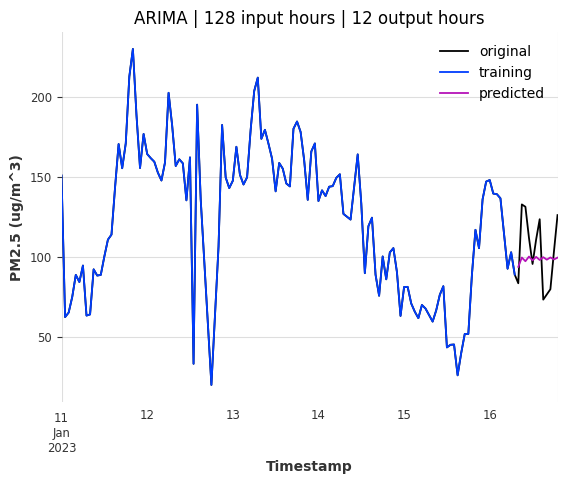

mae for this run : 18.930553268653515
10000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-57.853, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=149.180, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-54.677, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=38.586, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=748.695, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-59.844, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-58.973, Time=0.27 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-57.680, Time=0.50 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-55.992, Time=0.59 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-56.917, Time=0.28 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-58.108, Time=0.26 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-55.662, Time=0.71 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-43.748, Time=0.09 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 3.539 

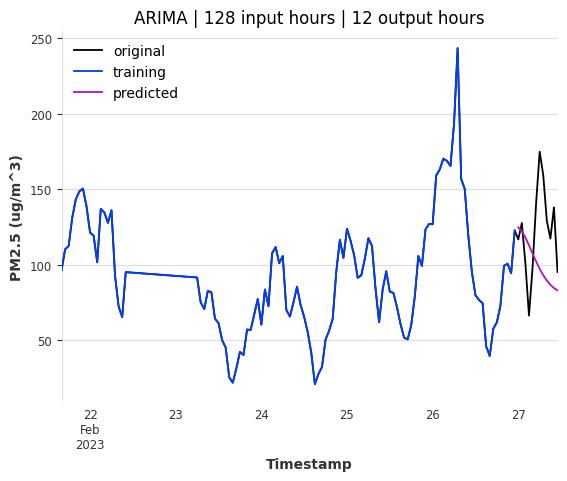

mae for this run : 33.782635584286645
11000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=174.887, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=331.253, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=179.552, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=238.820, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=702.316, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=170.063, Time=0.61 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=172.757, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=170.964, Time=1.30 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=171.006, Time=1.52 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=174.423, Time=0.28 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=173.134, Time=0.29 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=189.091, Time=0.11 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 5.742 sec

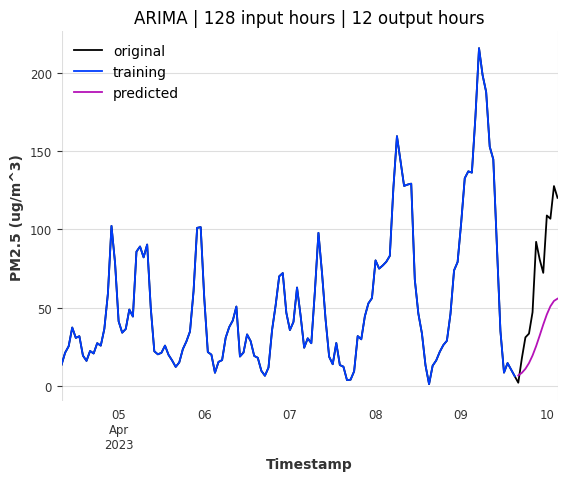

mae for this run : 40.5119578949173
12000
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=97.286, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=98.666, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=98.205, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=95.301, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.670 seconds
Best model order: p=0, d=1, q=0


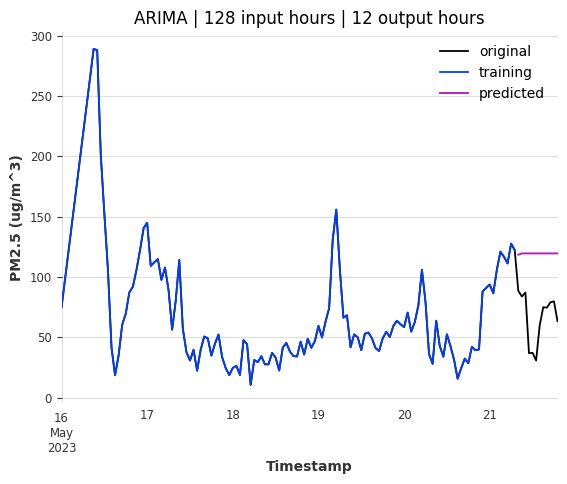

mae for this run : 53.128202161773935
13000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=199.418, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=254.901, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=200.799, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=205.917, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=672.264, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=195.945, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=199.091, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=197.921, Time=0.52 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=203.387, Time=0.43 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=201.410, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=200.695, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=233.605, Time=0.22 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 2.998 sec

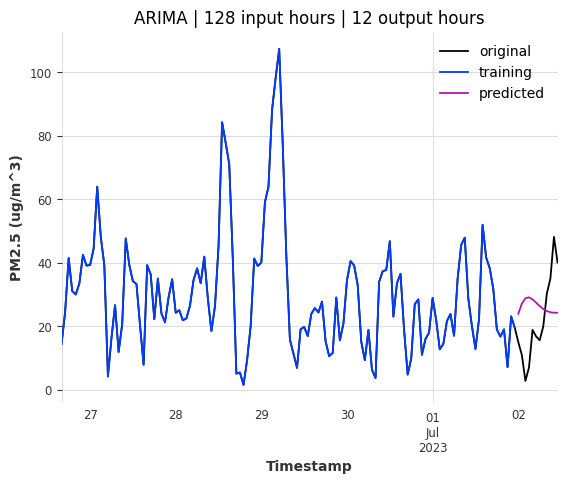

mae for this run : 13.790362817288674
14000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=15.222, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=26.359, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=17.726, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=19.215, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=658.608, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=17.217, Time=0.49 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=17.223, Time=0.38 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=20.990, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=18.012, Time=0.23 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=12.042, Time=0.57 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=12.539, Time=0.49 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=12.037, Time=0.51 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=12.825, Time=0.29 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=13.706, Time=0.68 sec
 ARIMA(2,0,4)(0,

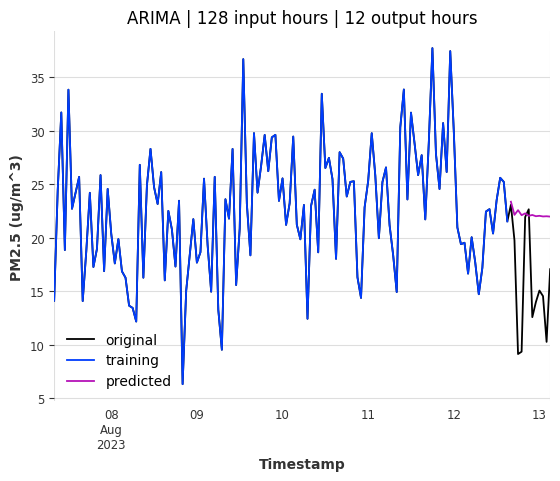

mae for this run : 6.53513064495077
15000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=135.966, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=250.659, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=134.756, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=183.541, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=682.028, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=135.760, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=137.552, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.848 seconds
Best model order: p=1, d=0, q=0


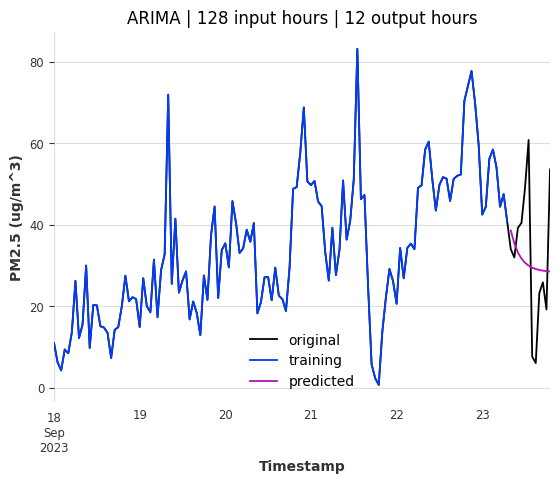

mae for this run : 13.356414689198493
16000
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-75.250, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-78.491, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-77.165, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-77.211, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-80.340, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.506 seconds
Best model order: p=0, d=1, q=0


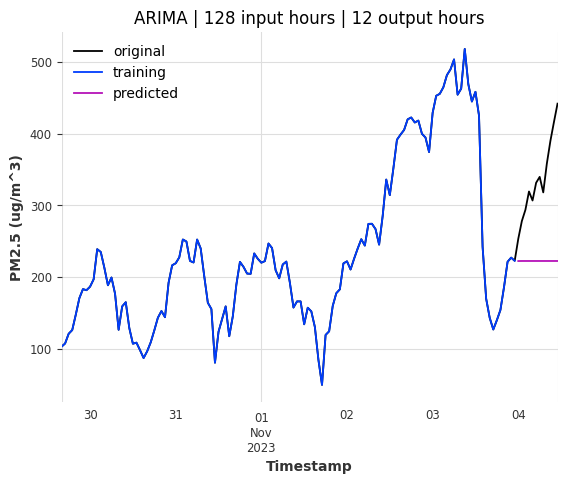

mae for this run : 114.87310712529552
17000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-91.173, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=132.222, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-77.750, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=15.624, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=780.485, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-107.955, Time=0.58 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-96.117, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-106.079, Time=0.56 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-89.125, Time=0.59 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-91.018, Time=0.49 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-96.980, Time=0.58 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-104.058, Time=1.52 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-78.995, Time=0.21 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 5.3

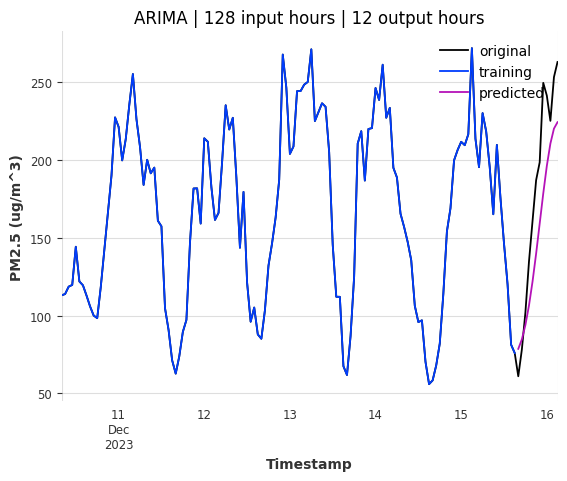

mae for this run : 32.40019472423939
[88.98281117273343, 19.22897346901429, 46.950272299160844, 6.110480994887151, 1.193769614964469, 14.152747895534207, 5.294575014774078, 23.402438241178853, 29.290161993395856, 18.930553268653515, 33.782635584286645, 40.5119578949173, 53.128202161773935, 13.790362817288674, 6.53513064495077, 13.356414689198493, 114.87310712529552, 32.40019472423939]
Overall MAE: 31.217488311458194


In [ ]:
inputhours = 128
outputhours = 12
mae_list = []
for start_idx in range(0, len(df_log) - (inputhours + outputhours), 1000):
    print(start_idx)
    current_chunk = df_log.iloc[start_idx:start_idx + inputhours + outputhours]
    input_df = current_chunk.head(inputhours)
    input_series = pd.Series(input_df, index=input_df.index)
    input_series.index = pd.to_datetime(input_series.index)
    adfuller(current_chunk)
    ts = TimeSeries.from_series(input_series)

    model = auto_arima(input_df, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,


                      start_P=0,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
    p, d, q = model.order
    print(f"Best model order: p={p}, d={d}, q={q}")
    model2 = ARIMA(p = p, d = d, q = 2)
    model2.fit(ts)
    pred = model2.predict(outputhours)
    pred_values = pred.values().flatten()  # Assuming `pred.values()` gives the forecasted values
    pred_index = pd.date_range(start=input_series.index[-1], periods=outputhours + 1, freq='H')[1:]
    pred_series = pd.Series(pred_values, index=pred_index)
    # print(pred_series)
    # Reverse the logarithmic transformation
    current_chunk_original = np.exp(current_chunk.values) - 1
    input_series_original = np.exp(input_series.values) - 1
    pred_series_original = np.exp(pred_series.values) - 1
    # print(current_chunk_original)
    current_new = pd.Series(current_chunk_original, index=current_chunk.index)
    train_new = pd.Series(input_series_original, index=input_series.index)
    pred_new = pd.Series(pred_series_original, index=pred_index)
    actual_values = current_new[inputhours:]
    mae = np.mean(np.abs(pred_new.values - actual_values.values))
    mae_list.append(mae)
    #print(pred_series_original)
    # Plotting
    fig, ax = plt.subplots()
    current_new.plot(ax=ax, label="original")
    train_new.plot(ax=ax, label="training")
    pred_new.plot(ax=ax, label="predicted")
    ax.legend()
    plt.title("ARIMA | 128 input hours | 12 output hours")
    plt.ylabel("PM2.5 (ug/m^3)")
    plt.show()
    print("mae for this run : " + str(mae))
    # print(metrics.ae(pd.Series(current_chunk), pred_new, intersect=True))
print(mae_list)
overall_mae = np.mean(mae_list)
print(f"Overall MAE: {overall_mae}")

In [ ]:
from darts.models import AutoARIMA
model = AutoARIMA(start_p=8, max_p=12, start_q=1)

0


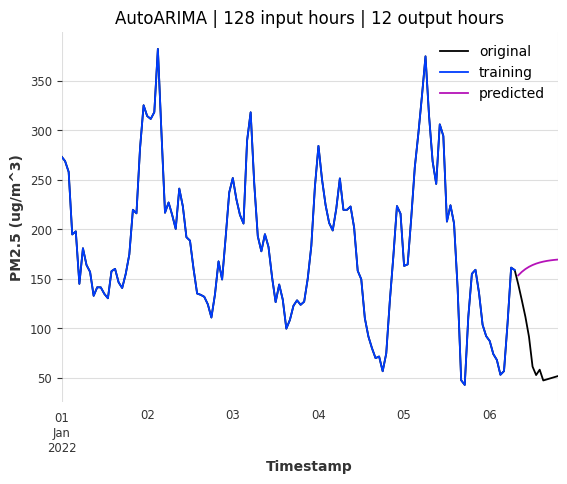

mae for this run : 89.5366056572804
1000


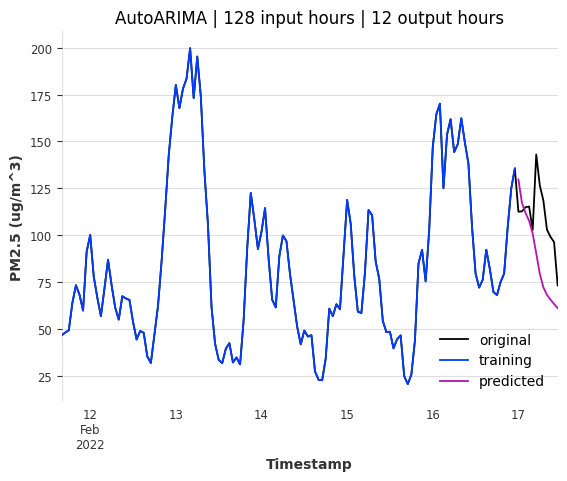

mae for this run : 24.47496121784223
2000


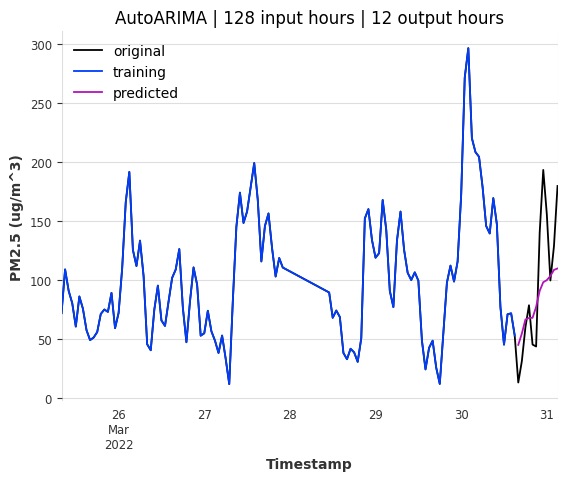

mae for this run : 35.3531628581169
3000


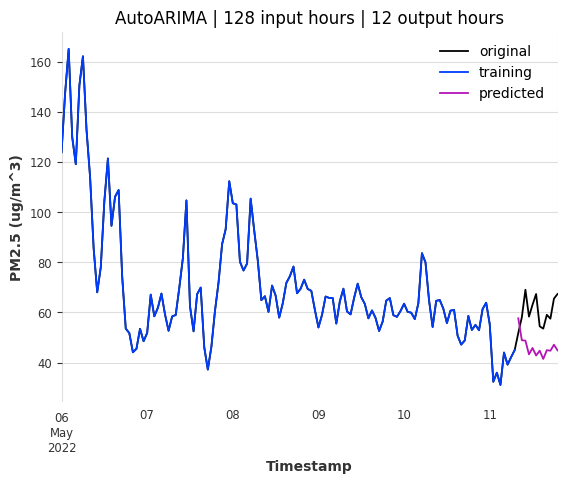

mae for this run : 15.167044716019644
4000


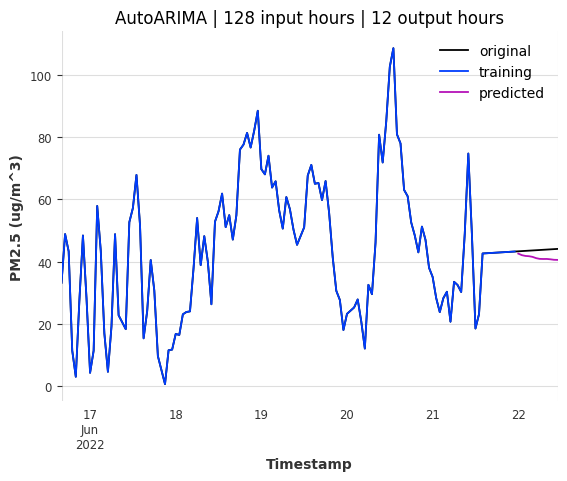

mae for this run : 2.417391296013242
5000


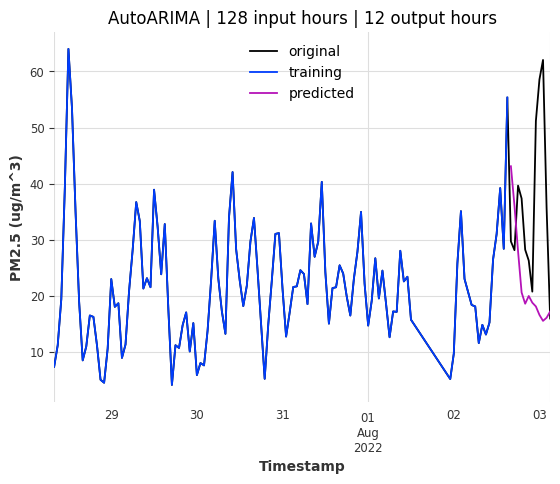

mae for this run : 17.492358847165022
6000


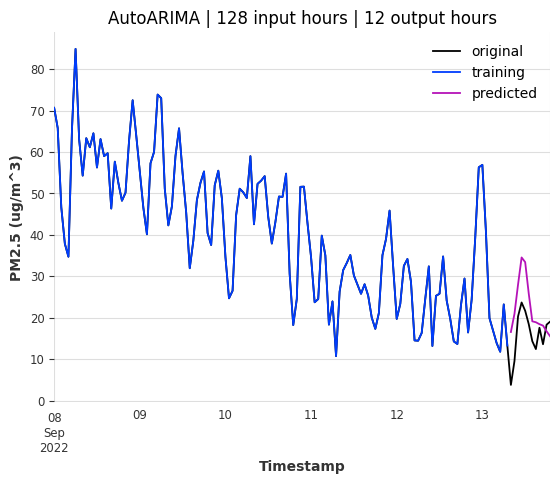

mae for this run : 6.967812469102548
7000


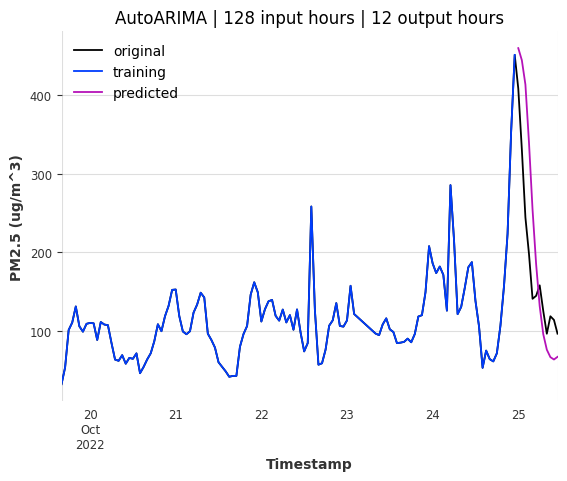

mae for this run : 69.59202971231943
8000


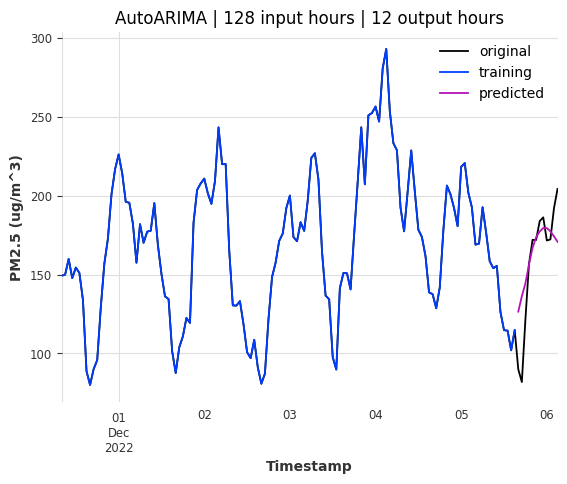

mae for this run : 16.55639577940425
9000


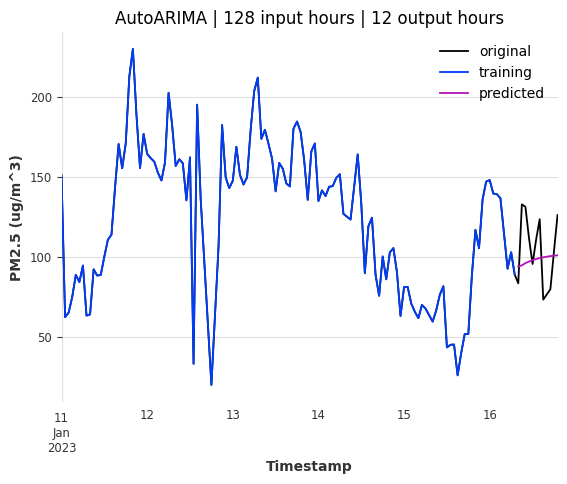

mae for this run : 19.637080313386495
10000


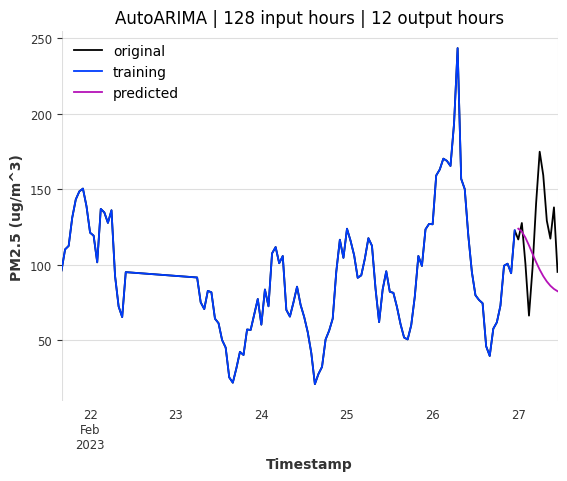

mae for this run : 34.037323468131454
11000


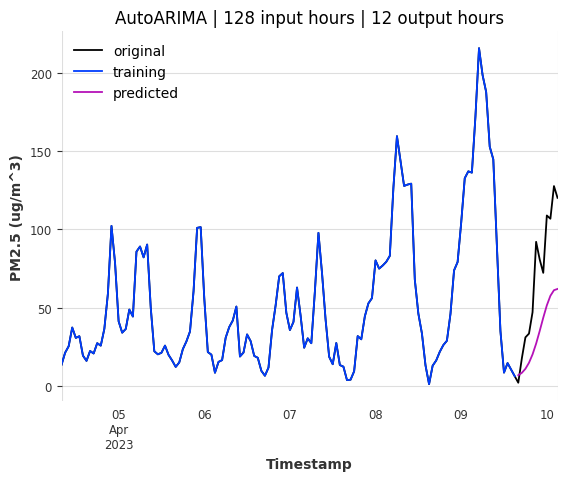

mae for this run : 37.57414109107507
12000


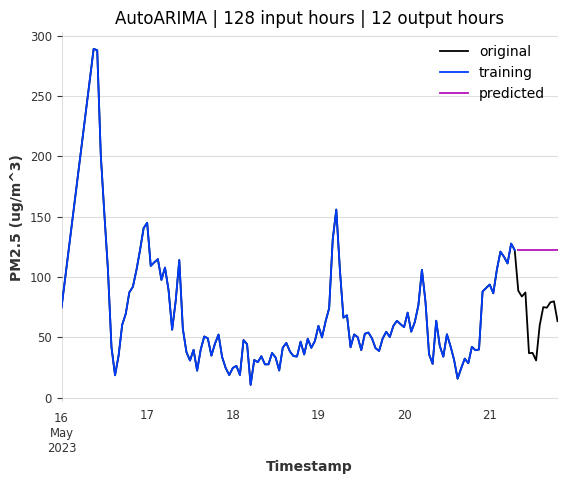

mae for this run : 56.004166666666656
13000


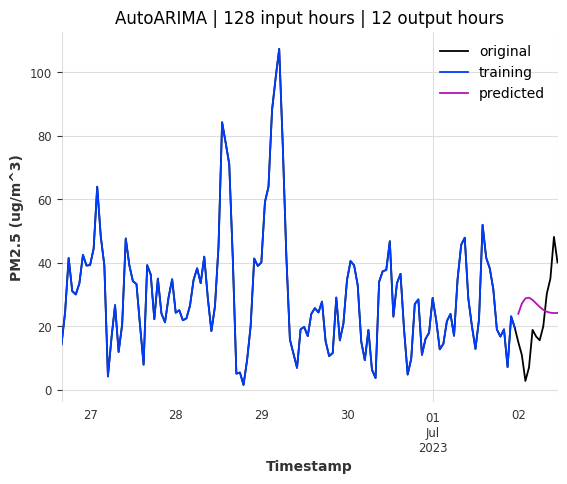

mae for this run : 13.748257753954064
14000


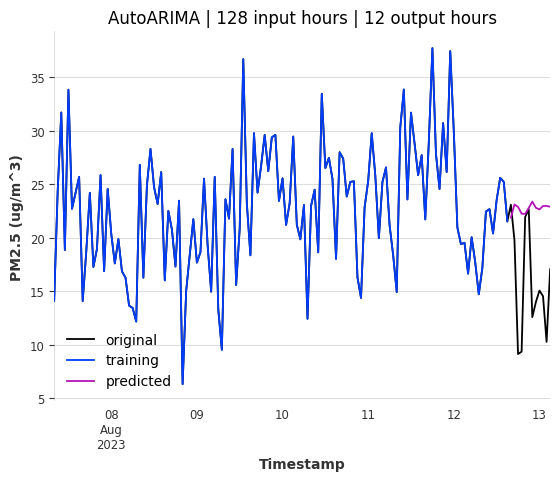

mae for this run : 7.143934181682687
15000


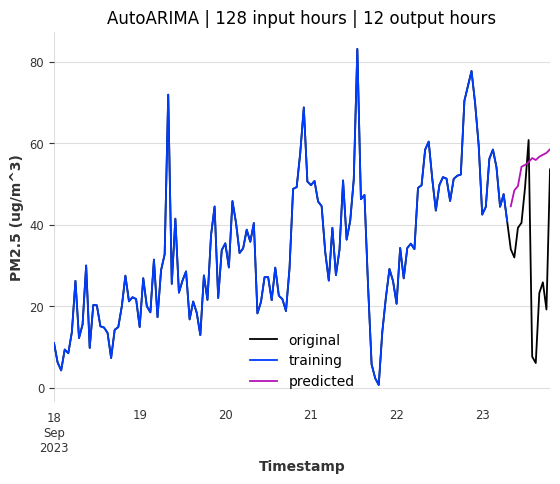

mae for this run : 22.412303832625252
16000


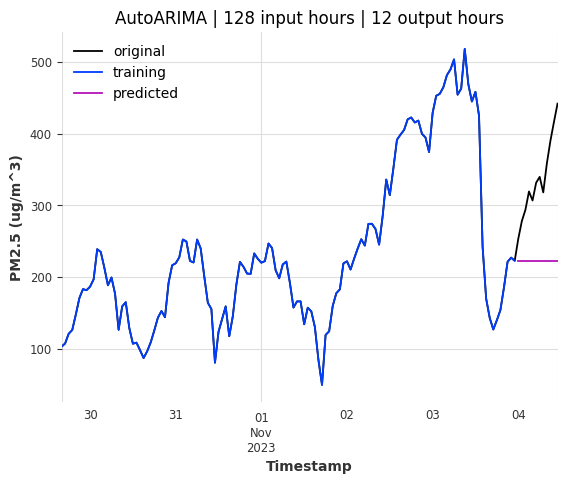

mae for this run : 114.57441666666665
17000


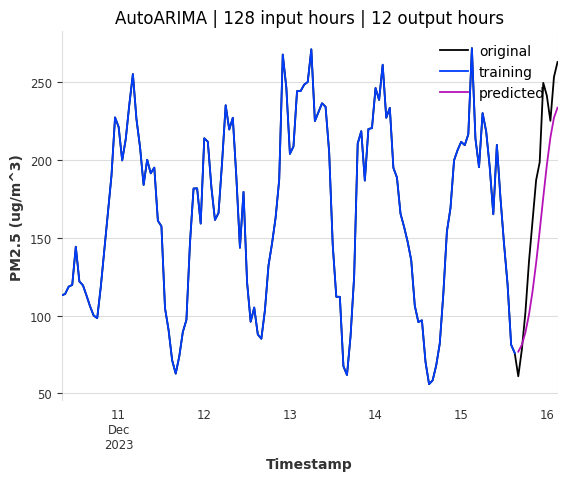

mae for this run : 32.7762497969287
[89.5366056572804, 24.47496121784223, 35.3531628581169, 15.167044716019644, 2.417391296013242, 17.492358847165022, 6.967812469102548, 69.59202971231943, 16.55639577940425, 19.637080313386495, 34.037323468131454, 37.57414109107507, 56.004166666666656, 13.748257753954064, 7.143934181682687, 22.412303832625252, 114.57441666666665, 32.7762497969287]
Overall MAE: 34.192535351354486


In [ ]:
inputhours = 128
outputhours = 12
mae_list = []
for start_idx in range(0, len(df_log) - (inputhours + outputhours), 1000):
    print(start_idx)
    current_chunk = df_log.iloc[start_idx:start_idx + inputhours + outputhours]


    input_df = current_chunk.head(inputhours)

    # Convert to TimeSeries
    input_series = pd.Series(input_df, index=input_df.index)
    input_series.index = pd.to_datetime(input_series.index)
    ts = TimeSeries.from_series(input_series)

    model.fit(ts)
    pred = model.predict(outputhours)


    # Extract p, d, q values




    # Extract prediction values and create a date range for the prediction
    pred_values = pred.values().flatten()  # Assuming `pred.values()` gives the forecasted values
    pred_index = pd.date_range(start=input_series.index[-1], periods=outputhours + 1, freq='H')[1:]
    pred_series = pd.Series(pred_values, index=pred_index)
    # print(pred_series)
    # Reverse the logarithmic transformation
    current_chunk_original = np.exp(current_chunk.values) - 1
    input_series_original = np.exp(input_series.values) - 1
    pred_series_original = np.exp(pred_series.values) - 1
    # print(current_chunk_original)
    current_new = pd.Series(current_chunk_original, index=current_chunk.index)
    train_new = pd.Series(input_series_original, index=input_series.index)
    pred_new = pd.Series(pred_series_original, index=pred_index)
    actual_values = current_new[inputhours:]
    mae = np.mean(np.abs(pred_new.values - actual_values.values))
    mae_list.append(mae)
    # Plotting
    fig, ax = plt.subplots()
    current_new.plot(ax=ax, label="original")
    train_new.plot(ax=ax, label="training")
    pred_new.plot(ax=ax, label="predicted")
    ax.legend()
    plt.title("AutoARIMA | 128 input hours | 12 output hours")
    plt.ylabel("PM2.5 (ug/m^3)")
    plt.show()
    print("mae for this run : " + str(mae))
print(mae_list)
overall_mae = np.mean(mae_list)
print(f"Overall MAE: {overall_mae}")


In [ ]:
from darts.models import Theta
model = Theta(theta = 2)

0


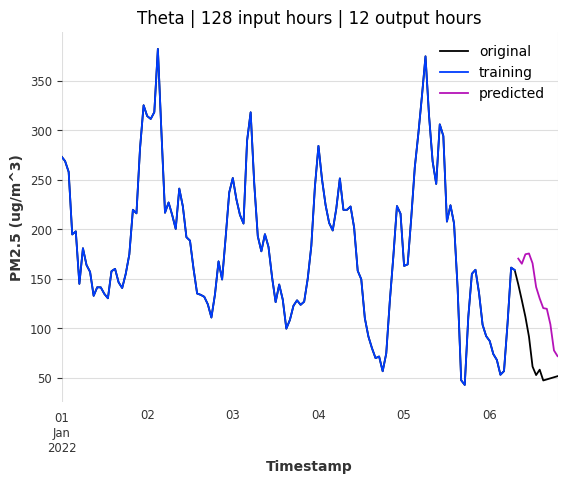

mae for this run : 60.09741997311624
1000


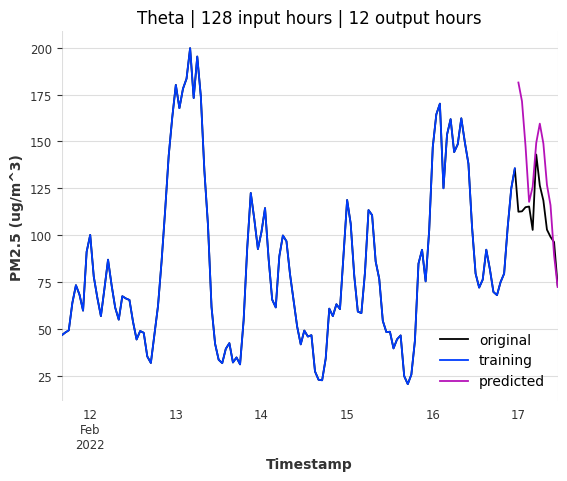

mae for this run : 25.33274054096736
2000


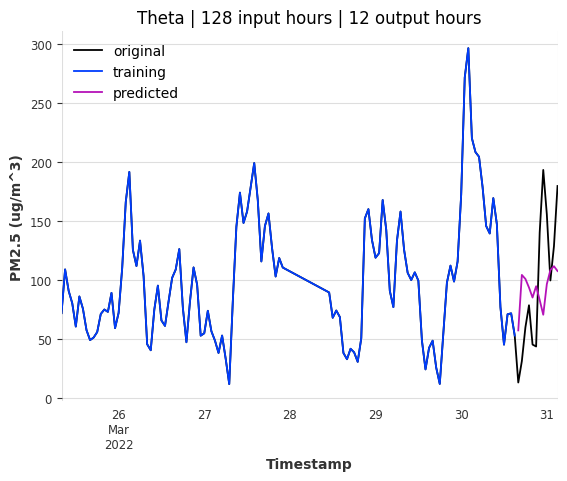

mae for this run : 50.23189765274302
3000


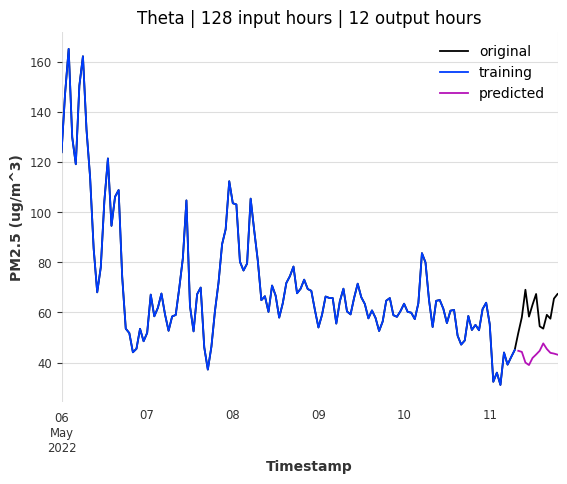

mae for this run : 16.992467893931902
4000


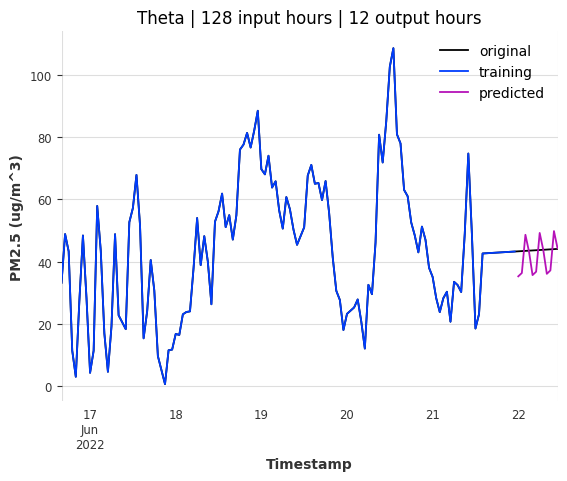

mae for this run : 5.114674814105029
5000


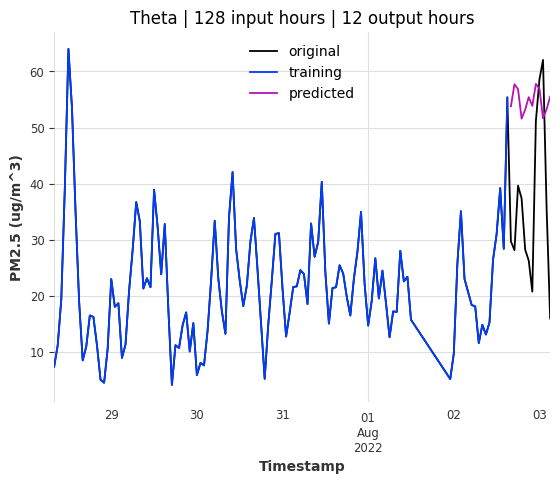

mae for this run : 20.654637980727216
6000


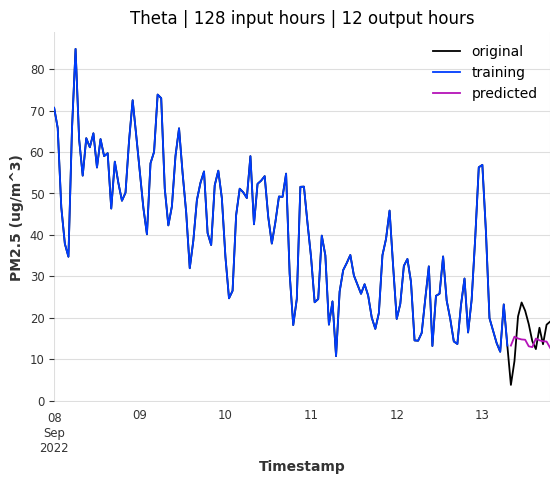

mae for this run : 5.010912176098161
7000


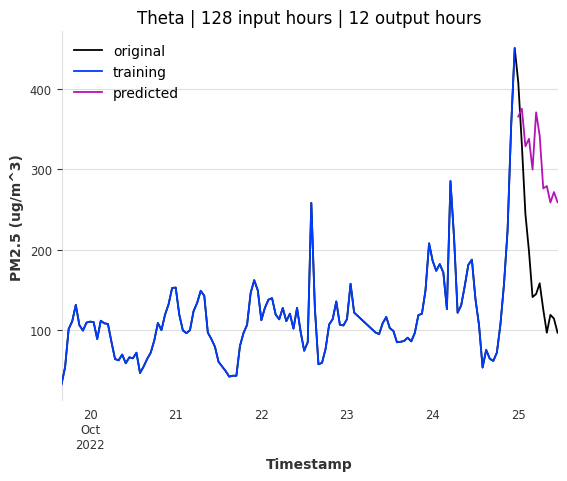

mae for this run : 139.2063688664215
8000


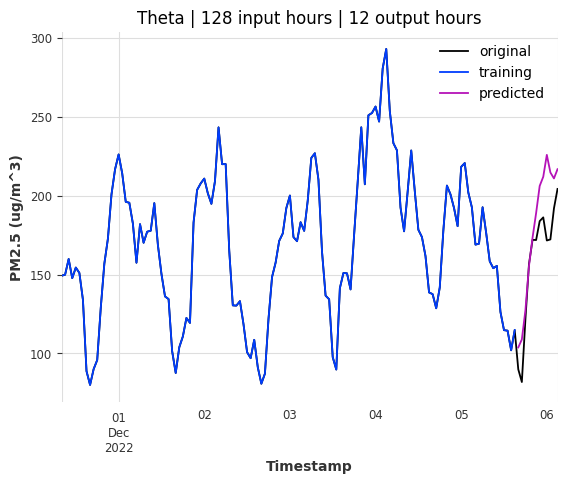

mae for this run : 20.234612811501197
9000


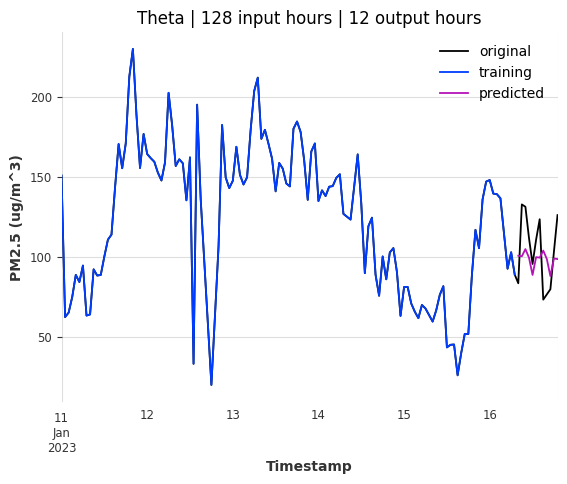

mae for this run : 18.573053912184257
10000


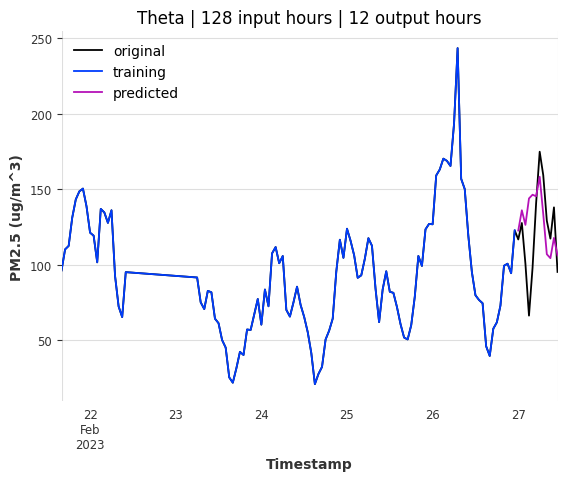

mae for this run : 23.303116240571995
11000


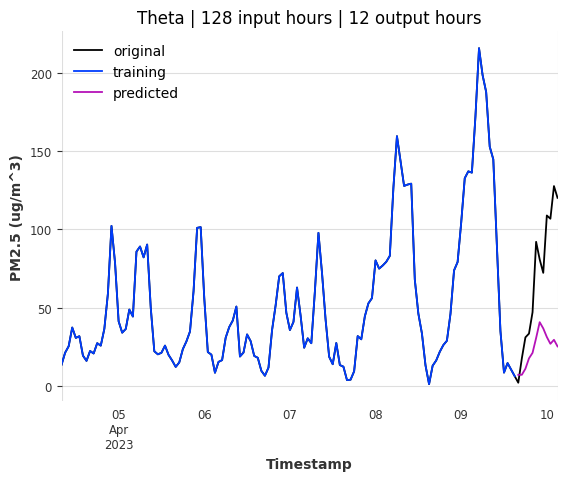

mae for this run : 47.117987840046304
12000


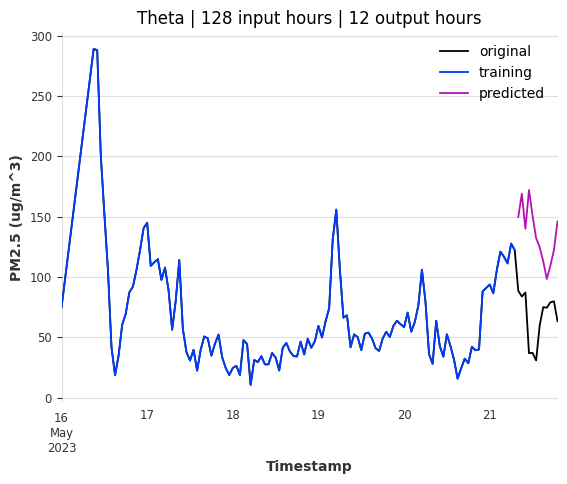

mae for this run : 69.3204709878078
13000


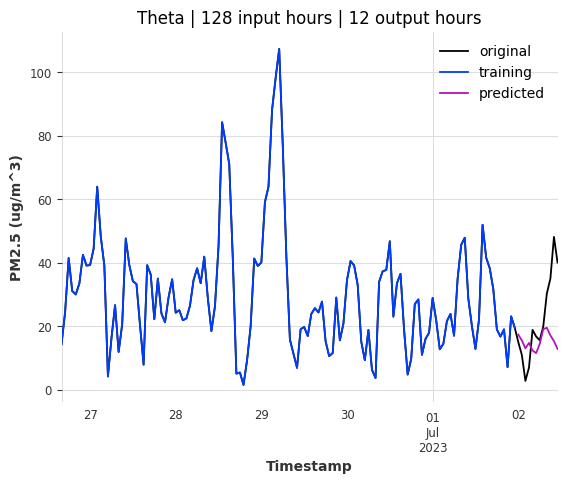

mae for this run : 10.618410381173854
14000


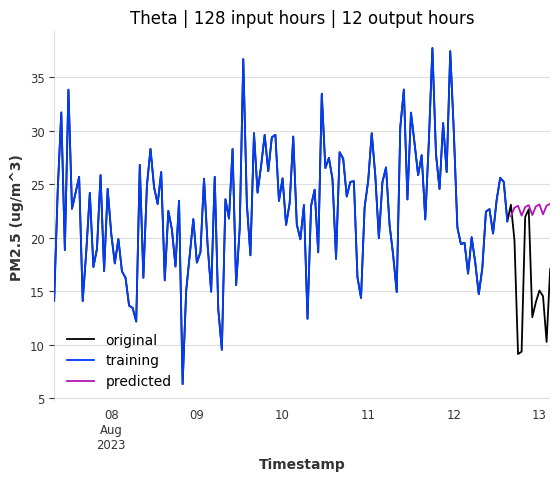

mae for this run : 7.082349616609012
15000


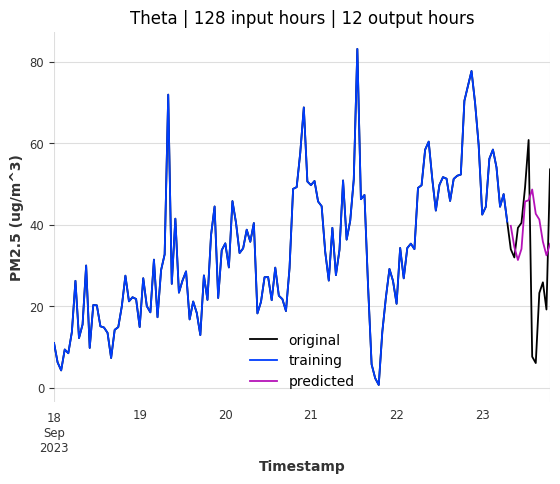

mae for this run : 14.853520844852286
16000


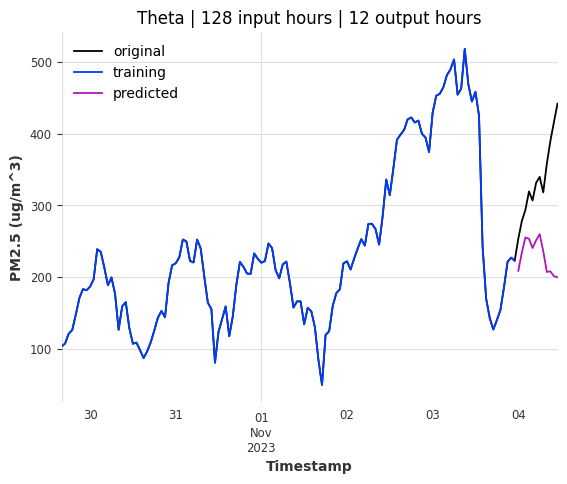

mae for this run : 107.70269706564763
17000


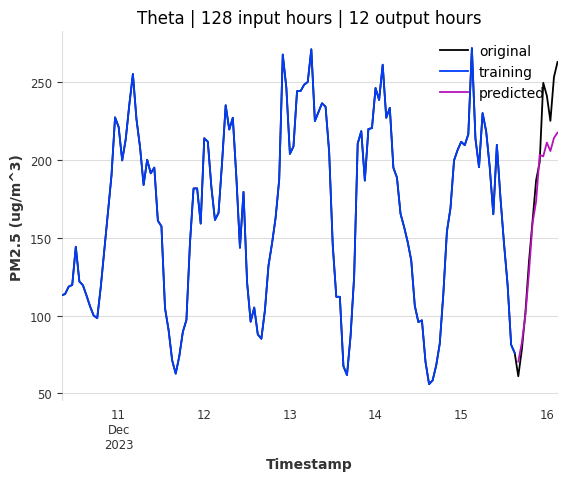

mae for this run : 18.653413388079297
[60.09741997311624, 25.33274054096736, 50.23189765274302, 16.992467893931902, 5.114674814105029, 20.654637980727216, 5.010912176098161, 139.2063688664215, 20.234612811501197, 18.573053912184257, 23.303116240571995, 47.117987840046304, 69.3204709878078, 10.618410381173854, 7.082349616609012, 14.853520844852286, 107.70269706564763, 18.653413388079297]
Overall MAE: 36.67226405481023


In [ ]:
inputhours = 128
outputhours = 12
mae_list = []
for start_idx in range(0, len(df_log) - (inputhours + outputhours), 1000):
    print(start_idx)
    current_chunk = df_log.iloc[start_idx:start_idx + inputhours + outputhours]
    input_df = current_chunk.head(inputhours)

    # Convert to TimeSeries
    input_series = pd.Series(input_df, index=input_df.index)
    input_series.index = pd.to_datetime(input_series.index)
    ts = TimeSeries.from_series(input_series)

    model.fit(ts)
    pred = model.predict(outputhours)

    # Extract prediction values and create a date range for the prediction
    pred_values = pred.values().flatten()  # Assuming `pred.values()` gives the forecasted values
    pred_index = pd.date_range(start=input_series.index[-1], periods=outputhours + 1, freq='H')[1:]
    pred_series = pd.Series(pred_values, index=pred_index)
    # print(pred_series)
    # Reverse the logarithmic transformation
    current_chunk_original = np.exp(current_chunk.values) - 1
    input_series_original = np.exp(input_series.values) - 1
    pred_series_original = np.exp(pred_series.values) - 1
    # print(current_chunk_original)
    current_new = pd.Series(current_chunk_original, index=current_chunk.index)
    train_new = pd.Series(input_series_original, index=input_series.index)
    pred_new = pd.Series(pred_series_original, index=pred_index)
    actual_values = current_new[inputhours:]
    mae = np.mean(np.abs(pred_new.values - actual_values.values))
    mae_list.append(mae)
    #print(pred_series_original)
    # Plotting
    fig, ax = plt.subplots()
    current_new.plot(ax=ax, label="original")
    train_new.plot(ax=ax, label="training")
    pred_new.plot(ax=ax, label="predicted")
    plt.title("Theta | 128 input hours | 12 output hours")
    plt.ylabel("PM2.5 (ug/m^3)")
    ax.legend()

    plt.show()
    print("mae for this run : " + str(mae))
print(mae_list)
overall_mae = np.mean(mae_list)
print(f"Overall MAE: {overall_mae}")

In [ ]:
from darts.models import Prophet
model = Prophet(country_holidays='IN')


/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/zp8aws8o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/q3b3ybey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51067', 'data', 'file=/tmp/tmpm7f6vb67/zp8aws8o.json', 'init=/tmp/tmpm7f6vb67/q3b3ybey.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modelmh3kul8r/prophet_model-20240520140954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:54 - cmdstanpy - INFO - Chain [1] start processing

0


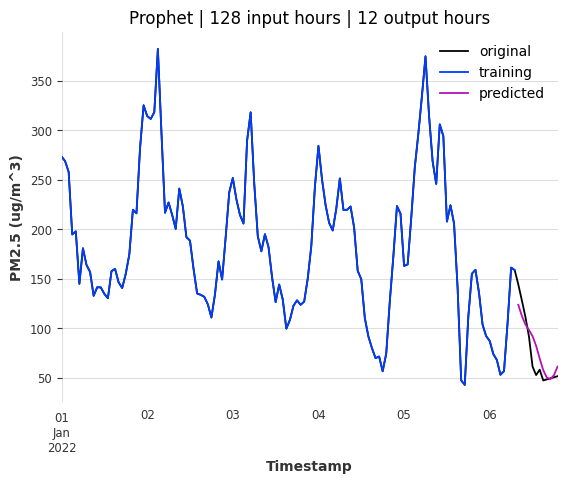

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/p5b5oh2k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/qlzm76nm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60376', 'data', 'file=/tmp/tmpm7f6vb67/p5b5oh2k.json', 'init=/tmp/tmpm7f6vb67/qlzm76nm.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modelucq3v0km/prophet_model-20240520140955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:55 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 12.2541140612388
1000


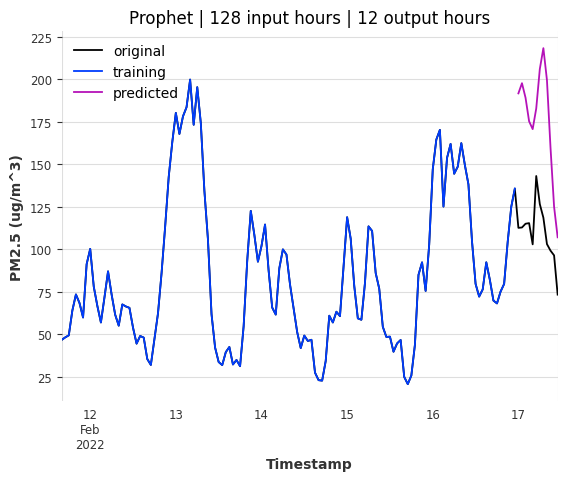

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/mqqy40u5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/5vggtfk7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58706', 'data', 'file=/tmp/tmpm7f6vb67/mqqy40u5.json', 'init=/tmp/tmpm7f6vb67/5vggtfk7.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modelo40o73n8/prophet_model-20240520140955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:55 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 66.99538464457939
2000


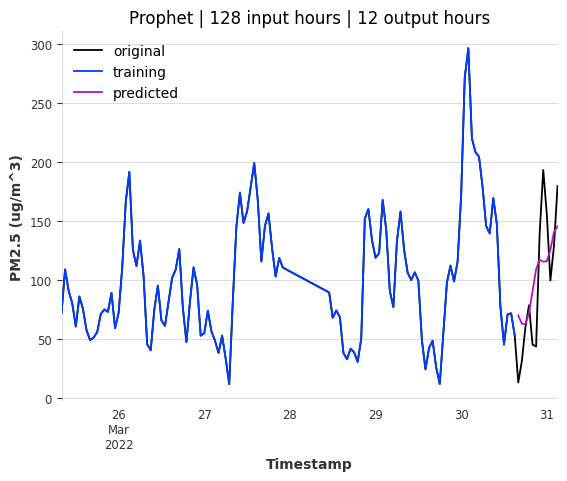

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/cjjf2fz5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/2rdgbzxb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42589', 'data', 'file=/tmp/tmpm7f6vb67/cjjf2fz5.json', 'init=/tmp/tmpm7f6vb67/2rdgbzxb.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modeleezz9fdu/prophet_model-20240520140956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:56 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 35.22372034690063
3000


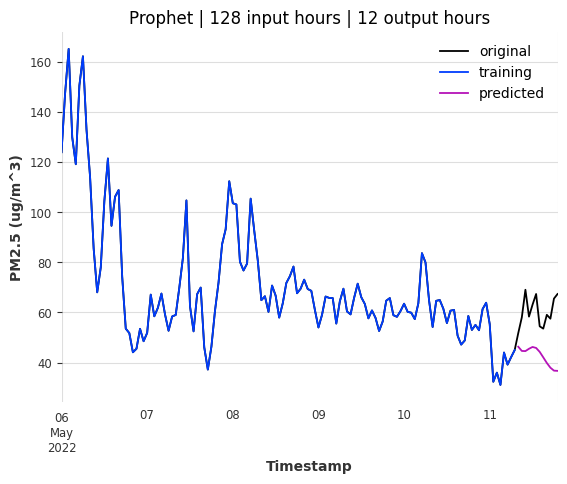

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/6qp9jf6w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/tbq74rt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57275', 'data', 'file=/tmp/tmpm7f6vb67/6qp9jf6w.json', 'init=/tmp/tmpm7f6vb67/tbq74rt5.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modelw5y_6w0p/prophet_model-20240520140956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:56 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 17.887358599986857
4000


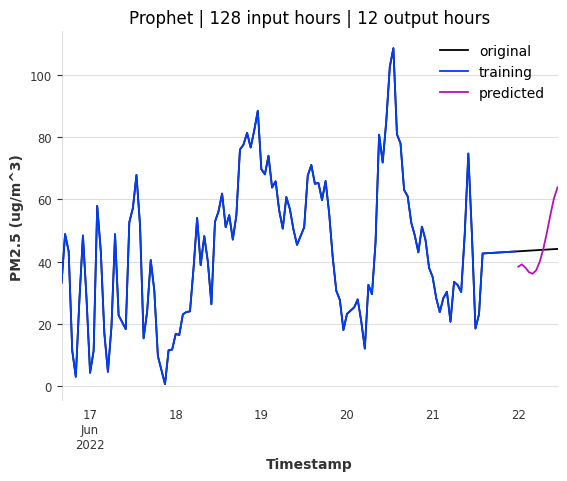

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/09n3sscz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/ow9138o5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79266', 'data', 'file=/tmp/tmpm7f6vb67/09n3sscz.json', 'init=/tmp/tmpm7f6vb67/ow9138o5.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modelzk4d56li/prophet_model-20240520140957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:57 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 7.662734026270378
5000


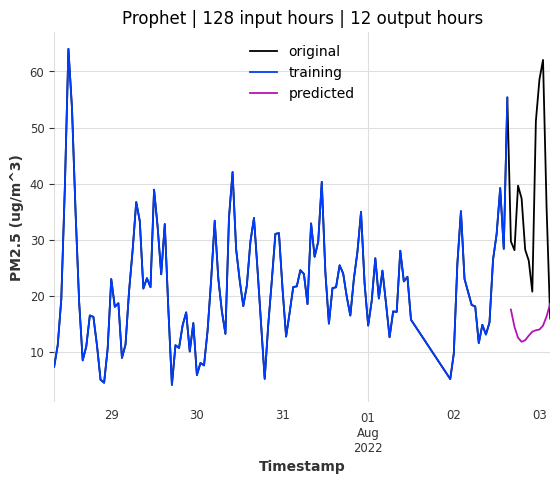

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/6ys7dwgz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/dx2ki_8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81375', 'data', 'file=/tmp/tmpm7f6vb67/6ys7dwgz.json', 'init=/tmp/tmpm7f6vb67/dx2ki_8f.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modell47yr1du/prophet_model-20240520140958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:58 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 22.18432442807398
6000


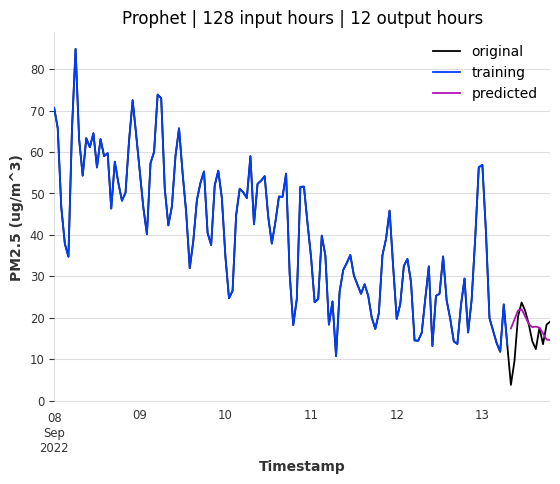

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/oft6ziwj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/y2_qxvzv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15250', 'data', 'file=/tmp/tmpm7f6vb67/oft6ziwj.json', 'init=/tmp/tmpm7f6vb67/y2_qxvzv.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modelle9u_oyl/prophet_model-20240520140958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:58 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 3.964333048099688
7000


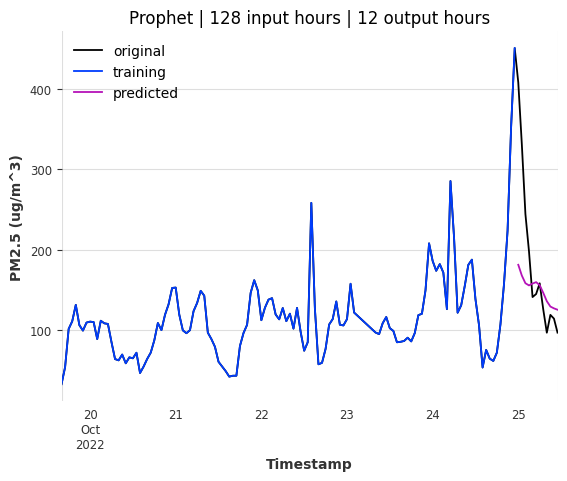

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/gpxh80pr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/7z5hsnp8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54507', 'data', 'file=/tmp/tmpm7f6vb67/gpxh80pr.json', 'init=/tmp/tmpm7f6vb67/7z5hsnp8.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modelrv7id81m/prophet_model-20240520140959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:59 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 55.27298397450838
8000


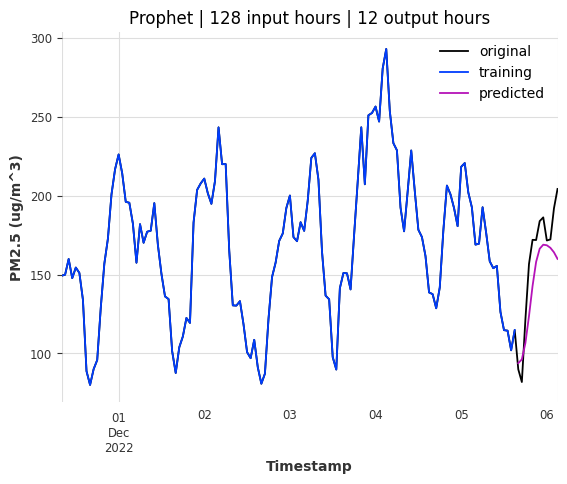

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/etkpxke1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/irg0y4o2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97559', 'data', 'file=/tmp/tmpm7f6vb67/etkpxke1.json', 'init=/tmp/tmpm7f6vb67/irg0y4o2.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modelgtsrc3o0/prophet_model-20240520141000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:00 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 18.757256466803494
9000


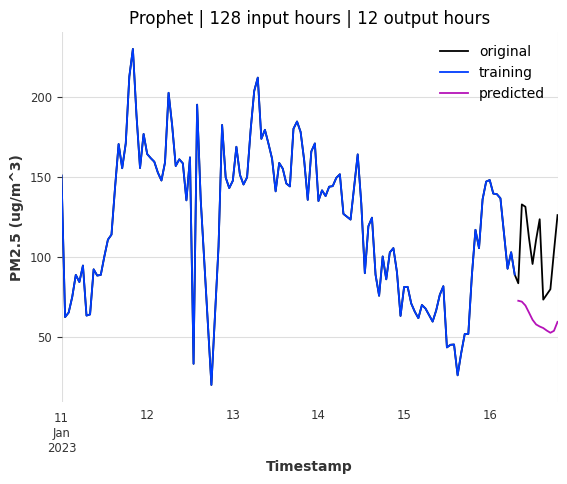

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/303tw0o8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/o0eufhmc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88766', 'data', 'file=/tmp/tmpm7f6vb67/303tw0o8.json', 'init=/tmp/tmpm7f6vb67/o0eufhmc.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modelk_1fhssd/prophet_model-20240520141000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:00 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 43.21645413450776
10000


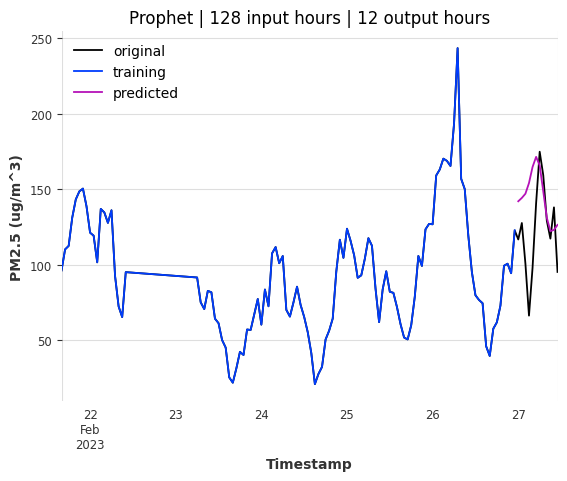

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/_atjwif6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/v8_q8ls1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52701', 'data', 'file=/tmp/tmpm7f6vb67/_atjwif6.json', 'init=/tmp/tmpm7f6vb67/v8_q8ls1.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modelkvnj8y16/prophet_model-20240520141001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:01 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 28.890123310567144
11000


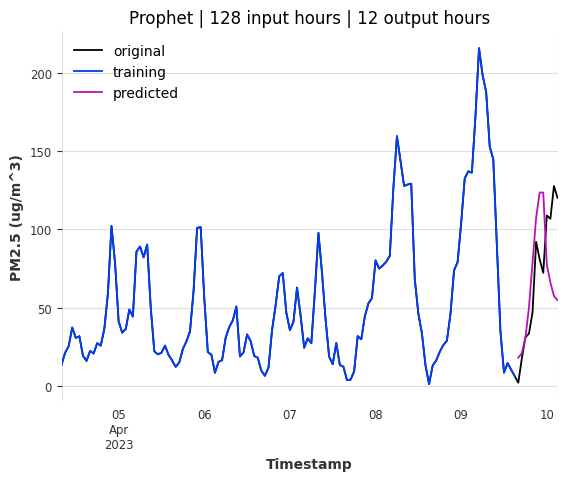

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/qckgc77x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/us4nu334.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86835', 'data', 'file=/tmp/tmpm7f6vb67/qckgc77x.json', 'init=/tmp/tmpm7f6vb67/us4nu334.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modeli5oa6ls_/prophet_model-20240520141001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:01 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 32.14193549265596
12000


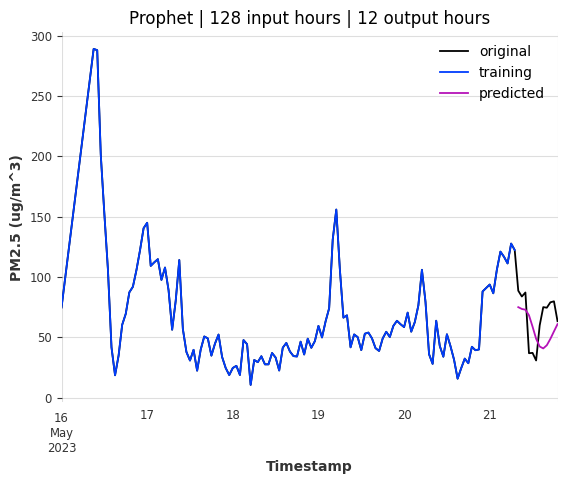

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/x0eiex4v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/py3wqf64.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50306', 'data', 'file=/tmp/tmpm7f6vb67/x0eiex4v.json', 'init=/tmp/tmpm7f6vb67/py3wqf64.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modely4n4s007/prophet_model-20240520141002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:02 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 20.827294794569074
13000


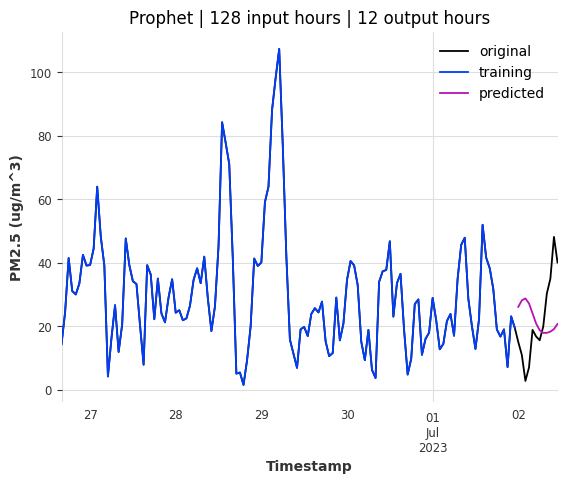

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/w9cx6vl2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/x5o8x9wv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87117', 'data', 'file=/tmp/tmpm7f6vb67/w9cx6vl2.json', 'init=/tmp/tmpm7f6vb67/x5o8x9wv.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modelqal9j1db/prophet_model-20240520141003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:03 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 13.860383030372986
14000


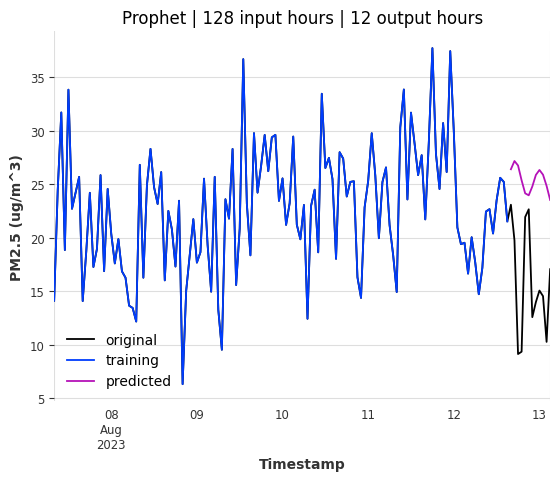

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/fly2mrr4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/uidoug32.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66351', 'data', 'file=/tmp/tmpm7f6vb67/fly2mrr4.json', 'init=/tmp/tmpm7f6vb67/uidoug32.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_model4arrrzlr/prophet_model-20240520141004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:04 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 9.630219856106068
15000


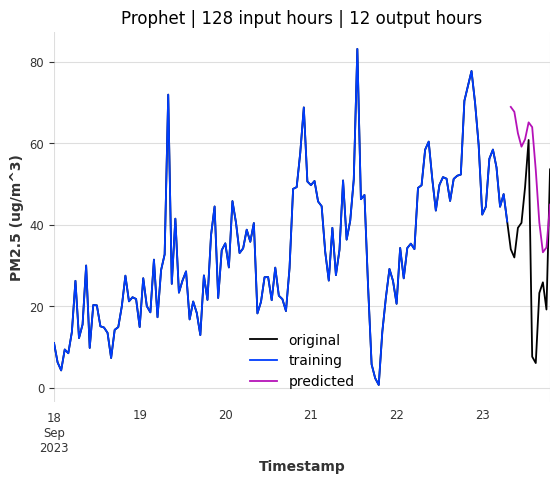

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/veh8x0sf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/qf02qelb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58096', 'data', 'file=/tmp/tmpm7f6vb67/veh8x0sf.json', 'init=/tmp/tmpm7f6vb67/qf02qelb.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_modelbf575zlr/prophet_model-20240520141005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:05 - cmdstanpy - INFO - Chain [1] start processing

mae for this run : 23.436813855309058
16000


14:10:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


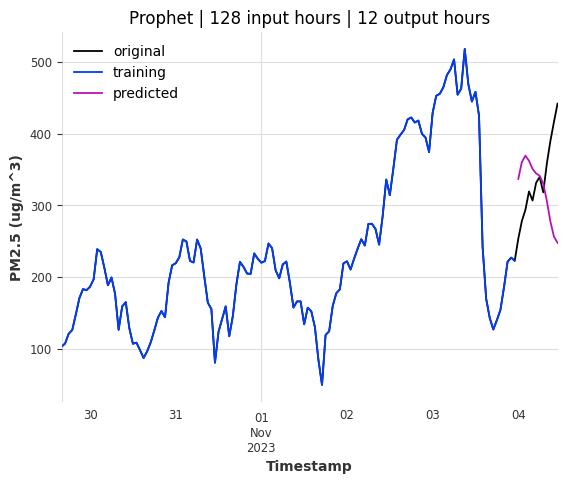

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/qw788wg4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm7f6vb67/u3jbd_dl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9049', 'data', 'file=/tmp/tmpm7f6vb67/qw788wg4.json', 'init=/tmp/tmpm7f6vb67/u3jbd_dl.json', 'output', 'file=/tmp/tmpm7f6vb67/prophet_model1zn4omt3/prophet_model-20240520141006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:06 - cmdstanpy - INFO - Chain [1] start processing


mae for this run : 72.80966607137746
17000


14:10:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


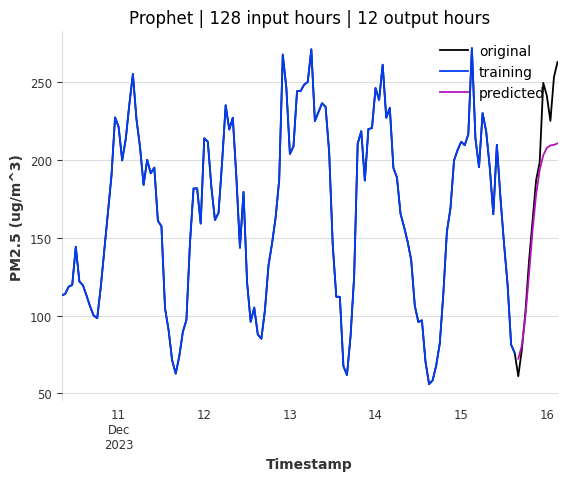

mae for this run : 19.711097676508697
[12.2541140612388, 66.99538464457939, 35.22372034690063, 17.887358599986857, 7.662734026270378, 22.18432442807398, 3.964333048099688, 55.27298397450838, 18.757256466803494, 43.21645413450776, 28.890123310567144, 32.14193549265596, 20.827294794569074, 13.860383030372986, 9.630219856106068, 23.436813855309058, 72.80966607137746, 19.711097676508697]
Overall MAE: 28.04034432324643


In [ ]:
inputhours = 128
outputhours = 12
mae_list = []
for start_idx in range(0, len(df_log) - (inputhours + outputhours), 1000):
    print(start_idx)
    current_chunk = df_log.iloc[start_idx:start_idx + inputhours + outputhours]
    input_df = current_chunk.head(inputhours)

    # Convert to TimeSeries
    input_series = pd.Series(input_df, index=input_df.index)
    input_series.index = pd.to_datetime(input_series.index)
    ts = TimeSeries.from_series(input_series)

    model.fit(ts)
    pred = model.predict(outputhours)

    # Extract prediction values and create a date range for the prediction
    pred_values = pred.values().flatten()  # Assuming `pred.values()` gives the forecasted values
    pred_index = pd.date_range(start=input_series.index[-1], periods=outputhours + 1, freq='H')[1:]
    pred_series = pd.Series(pred_values, index=pred_index)
    # print(pred_series)
    # Reverse the logarithmic transformation
    current_chunk_original = np.exp(current_chunk.values) - 1
    input_series_original = np.exp(input_series.values) - 1
    pred_series_original = np.exp(pred_series.values) - 1
    # print(current_chunk_original)
    current_new = pd.Series(current_chunk_original, index=current_chunk.index)
    train_new = pd.Series(input_series_original, index=input_series.index)
    pred_new = pd.Series(pred_series_original, index=pred_index)
    actual_values = current_new[inputhours:]
    mae = np.mean(np.abs(pred_new.values - actual_values.values))
    mae_list.append(mae)
    #print(pred_series_original)
    # Plotting
    fig, ax = plt.subplots()
    current_new.plot(ax=ax, label="original")
    train_new.plot(ax=ax, label="training")
    pred_new.plot(ax=ax, label="predicted")
    plt.title("Prophet | 128 input hours | 12 output hours")
    plt.ylabel("PM2.5 (ug/m^3)")
    ax.legend()

    plt.show()
    print("mae for this run : " + str(mae))
print(mae_list)
overall_mae = np.mean(mae_list)
print(f"Overall MAE: {overall_mae}")